# DAE Models implementation in Julia
1. This file contains DAE models implementation in Julia for all 6 six models and their simulation at operating conditions with plottings.
2. It also contains the heat exchanger profile diagrams

In [11]:
#Author:Madhusudhan Pandey, USN, EPE
#Date: March 17, 2019
figpath = "C:/Users/pande/Desktop/Desktop/Thesis/ThesisLyx/figures/chapter3/";

using DifferentialEquations
using Sundials
using Plots
using Plots.PlotMeasures
using JLD
# for more info see: https://docs.juliaplots.org/latest/attributes/
pyplot();
using LaTeXStrings;


#Specifying Parameters
pa = 1.01e5 # " Atmospheric pressure , Pa "
#
chpa = 1.15 # " Specific heat capacity air , kJ.kg -1. K -1 # " 
chpw = 4.2 # " Specific heat capacity water , kJ.kg -1. K -1 # " 
chpCu = 0.385 # " Specific heat capacity copper , kJ.kg -1. K -1 # " 
chpFe = 0.465 # " Specific heat capacity iron , kJ.kg -1. K -1 # " 
#
mr = 9260. # " Mass of copper in rotor , kg # " 
ms = 6827. # " Mass of copper in stator , kg # " 
mFe = 71200. # " Mass of iron in stator , kg # " 
#
VhCu = 0.112e-3 # " Specific volume of copper , m3 / kg # " 
VhFe = 0.127e-3 # " Specific volume of iron , m3 / kg # " 
#
Vr = mr*VhCu # " Rotor copper volume , m3 # " 
Vs = ms*VhCu # " Stator copper volume , m3 # " 
VFe = mFe*VhFe # " Stator iron volume , m3 # " 
#
hAax = 55.6 #"Heat transfer ,air inside heat exchanger ,kW/K";
hAwx = 222. #"Heat transfer ,water inside heat exchanger ,kW/K";
UAx = 1/(1/hAax+1/hAwx) #"Heat transfer ,heat exchanger ,kW/K"
#UAx=44.46=UPLx if Lx=1m then Up=44.46
Up=44.46 # "Product of overall heat transfer and perimeter"
#
UAr2d = 2.7 # " Heat transfer , rotor copper to air gap , kW / K # " 
UAs2Fe = 20. # " Heat transfer , stator copper to stator iron , kW /K" 
UAFe2a = 14.3 # " Heat transfer , rotor iron to hot air , kW / K # " 
#
Hha_o = 0. # " Enthalpy of formation air , kJ / kg " 
HhCu_o = 0. # " Enthalpy of formation copper , kJ / kg # " 
HhFe_o = 0. # " Enthalpy of formation iron , kJ / kg # " 
#
Ta_o = 25. # " Standard state temperature air , C # " 
TCu_o = 25. # " Standard state temperature copper , C # " 
TFe_o = 25. # " Standard state temperature iron , C # " 


#
Rr = 0.127e-3 # " Ohmic resistance , rotor copper , kOhm, at 25 C # " 
Rs = 1.95e-6 # " Ohmic resistance , stator copper , kOhm, at 25 C"
#
alphaCu = 0.00404 # Temperature coefficient of resistance for copper
R = 8.314 # " J.K-1.mol-1 # "
MCu = 63.54 # " Molecular mass of Copper, g/mol"
MFe = 55.84 # "Molecular mass of Iron, g/mol"
Ma = 28.97 # "Molecular mass of Air, g/mol"
Mw = 18.01 # "Molecular mass of Water, g/mol"
# Linear approximation of NASA lewis coefficients for air, water, copper and iron
aa,ba,aw,bw,aCu,bCu,aFe,bFe=3.28,0.000672,3.63,0.001272,2.56,0.001200,0.19,0.00676
#vectors of parameters
par = [pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,hAax,hAwx,UAx,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,alphaCu,aa,ba,aw,bw,aCu,bCu,aFe,bFe,R,Ma,Mw,MCu,MFe,Up];

In [12]:
function model1()
    #creating a model
    function model1_DAE(err,dxdt,x,par,t)
        #
        # Naming derivatives of differential variables
        dUrdt = dxdt[1]
        dUsdt = dxdt[2]
        dUFedt = dxdt[3]
        # Naming differential variables
        Ur = x[1]
        Us = x[2]
        UFe = x[3]
        # Naming algebraic variables
        Qdrs= x[4] # " Heat flow source in rotor copper , kW "
        Qdss = x[5] # " Heat flow source in stator copper , kW "
        Qdfs = x[6] # " Heat flow source due to friction loss , kW "
        Qdr2d = x[7] # " Heat flow from rotor copper to air gap , kW "
        Qds2Fe = x[8] # " Heat flow from stator copper to stator iron , kW "
        QdFe2a = x[9] # " Heat flow from stator iron to hot air , kW "
        #
        Hr = x[10] # " Enthalpy of rotor copper , kJ "
        Hs = x[11] # " Enthalpy of stator copper , kJ "
        HFe = x[12] # " Enthalpy of stator iron , kJ " 
        Hhr = x[13] # " Specific enthalpy of rotor copper , kJ / kg "
        Hhs = x[14] # " Specific enthalpy of stator copper , kJ / kg "
        HhFe = x[15] # " Specific enthalpy of stator iron , kJ / kg "
        #
        Hdac = x[16] # " Convective enthalpy of cold air , kW "
        Hdad = x[17] # " Convective enthalpy of air gap air , kW "
        Hdah = x[18] # " Convective enthalpy of hot air , kW " 
        Hhac = x[19] # " Specific enthalpy of cold air , kJ / kg "
        Hhad = x[20] # " Specific enthalpy of air gap air , kJ / kg "
        Hhah = x[21] # " Specific enthalpy of hot air , kJ / kg "
        #
        NStw = x[22]
        NSta = x[23]
        NStd = x[24]
        Qdw2a = x[25]
        #
        Twh = x[26] # " Hot water temperature , C " 
        Tac = x[27] # " Cold air temperature , C "
        Tad = x[28] # " Air gap air temperature , C "
        Tah = x[29] # " Hot air temperature , C "
        #
        Tr = x[30] # " Temperature of rotor copper , C " 
        Ts = x[31] # " Temperature of stator copper , C "
        TFe = x[32] # " Temperature of stator iron , C "

        pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,hAax,hAwx,UAx,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,alphaCu,aa,ba,aw,bw,aCu,bCu,aFe,bFe,R,Ma,Mw,MCu,MFe,Up = par

        # Computing inputs
        Twc = u_Twc(t)
        Ifd = u_Ifd(t)
        It = u_It(t)
        QdFes = u_QdFes(t)
        Wdf = u_Wdf(t)
        mdw = u_mdw(t)
        mda = u_mda(t)
        #
        # Equations
        #----------
        # - Algebraic equations
        err[1] = Hdac - Hdad + Qdr2d + Qdfs
        err[2] = Hdad - Hdah + QdFe2a

        err[3] = -Qdrs + 1.1* Rr * Ifd ^2
        err[4] = -Qdss + 3.0* Rs * It ^2
        err[5] = -Qdr2d + UAr2d *( Tr - Tad )
        err[6] = -Qds2Fe + UAs2Fe *( Ts - TFe )
        err[7] = -QdFe2a + UAFe2a *( TFe - Tah )
        err[8] = -Qdfs + 0.8* Wdf

        err[9] = -Hhr + HhCu_o + chpCu *( Tr - TCu_o )
        err[10] = -Hhs + HhCu_o + chpCu *( Ts - TCu_o )
        err[11] = -HhFe + HhFe_o + chpFe *( TFe - TFe_o )
        err[12] = -Hhac + Hha_o + chpa *( Tac - Ta_o )
        err[13] = -Hhad + Hha_o + chpa *( Tad - Ta_o )
        err[14] = -Hhah + Hha_o + chpa *( Tah - Ta_o )

        err[15] = -Hr+ mr * Hhr 
        err[16] = -Hs + ms * Hhs 
        err[17] = -HFe + mFe * HhFe

        err[18] = -Ur + Hr - pa * Vr
        err[19] = -Us + Hs - pa * Vs
        err[20] = -UFe + HFe - pa * VFe
        #
        err[21] = -Hdac + mda * Hhac 
        err[22] = -Hdad + mda * Hhad
        err[23] = -Hdah + mda * Hhah
        #
        err[24] = -Twh + (NStw*(1 - exp(-NStd))*Tah+NStd*exp(-NStd)*Twc)/(NStw-NSta*exp(-NStd))
        err[25] = -Tac + (NStd*Tah+NSta*(1 - exp(-NStd))*Twc)/(NStw-NSta*exp(-NStd))
        err[26] = -Qdw2a + (exp(-NStd)-1.)*(Twc-Tah)/(1/(chpa*mda)*exp(-NStd)-1/(chpw*mdw))
        err[27] = -NStw + UAx/(chpw*mdw)
        err[28] = -NSta + UAx/(chpa*mda)
        err[29] = -NStd + NStw-NSta

        # - differential equations
        err[30] = -dUrdt + Qdrs - Qdr2d
        err[31] = -dUsdt + Qdss - Qds2Fe
        err[32] = -dUFedt + QdFes + Qds2Fe - QdFe2a
        #
        return err
    end
    #
    function u_Twc(t)
        return 3.8 # deg C
    end
    #
    function u_Ifd(t)
        return 1055. # A
    end
    #
    function u_It(t)
        return 5360. # A
    end
    #
    function u_QdFes(t)
        return 212. # kW
    end
    #
    function u_Wdf(t)
        return 528. # kW
    end
    #
    function u_mdw(t)
        return 53.9 # kg/s
    end
    #
    function u_mda(t)
        return 49.2 # kg/s
    end

    #Initial state parameters
    Tr0 = 28.  #Initial temperature of rotor copper temperature , C 
    Ts0 = 29.  #Initial temperature of stator copper temperature , C
    TFe0 = 30.  #Initial temperature of stator iron temperature , C 
    Hhr0 = HhCu_o + chpCu *( Tr0 - TCu_o )  #Initial rotor specific enthalpy , kJ / kg  
    Hhs0 = HhCu_o + chpCu *( Ts0 - TCu_o )  #Initial stator copper specific enthalpy , kJ / kg  
    HhFe0 = HhFe_o + chpFe *( TFe0 - TFe_o )  #Initial stator iron specific enthalpy , kJ / kg  
    Hr0 = mr * Hhr0  #Initial rotor enthalpy , kJ  
    Hs0 = ms * Hhs0  #Initial stator copper enthalpy , kJ  
    HFe0 = mFe * HhFe0  #Initial stator iron enthalpy , kJ  
    Ur0 = Hr0 - pa * Vr  #Initial rotor copper #internal energy , kJ  
    Us0 = Hs0 - pa * Vs  #Initial stator copper #internal energy , kJ 
    UFe0 = HFe0 - pa * VFe  #Initial stator iron #internal energy , kJ

    #Initial values for algebriac variables
    x0 = zeros(32,1)
    x0[1] = Ur0
    x0[2] = Us0
    x0[3] = UFe0
    x0[4] = 1.1* Rr * u_Ifd(0)^2
    x0[5] = 3.0* Rs * u_It(0)^2
    x0[6] = 0.8* u_Wdf(0)
    x0[7] = UAr2d * Tr0
    x0[8] = UAs2Fe * Ts0
    x0[9] = UAFe2a * TFe0
    x0[10] = Hr0 
    x0[11] = Hs0
    x0[12] = HFe0
    x0[13] = Hhr0
    x0[14] = Hhs0
    x0[15] = HhFe0
    x0[16] = u_mda(0) * x0[20]
    x0[17] = u_mda(0) * x0[21]
    x0[18] = u_mda(0) * x0[22]
    x0[19] = Hha_o 
    x0[20] = Hha_o 
    x0[21] = Hha_o 
    x0[22] = UAx/chpw/u_mdw(0)
    x0[23] = UAx/chpa/u_mda(0)
    x0[24] = x0[22]-x0[23]
    x0[25] = (exp(-x0[24])-1)*(u_Twc(0)-Ta_o)/(1/(chpa*u_mda(0))*exp(-x0[24])-1/(chpw*u_mdw(0)))
    x0[26] = u_Twc(0)
    x0[27] = Ta_o
    x0[28] = Ta_o
    x0[29] = Ta_o
    x0[30] = Tr0
    x0[31] = Ts0
    x0[32] = TFe0
    # Initial derivatives
    dxdt0 = zeros(32,1)
    dxdt0[1]= x0[4]-x0[7]
    dxdt0[2]= x0[5]-x0[8]
    dxdt0[3]= u_QdFes(0)+x0[8]-x0[9]
    # Specifying differential variables
    diff_vars = fill(false,32)
    diff_vars[1],diff_vars[2],diff_vars[3]=true,true,true
    # Time span
    tspan = (0.0,500*60.)
    # Problem definition
    prob_model1_DAE = DAEProblem(model1_DAE,dxdt0,x0,tspan,par,differential_vars=diff_vars)
    sol_model1_DAE = solve(prob_model1_DAE,IDA());
    return sol_model1_DAE
end

model1 (generic function with 1 method)

In [13]:
# Model 2
function model2()
    #creating a model
    function model2_DAE(err,dxdt,x,par,t)
        #
        # Naming derivatives of differential variables
        dUrdt = dxdt[1]
        dUsdt = dxdt[2]
        dUFedt = dxdt[3]
        # Naming differential variables
        Ur = x[1]
        Us = x[2]
        UFe = x[3]
        # Naming algebraic variables
        Qdrs= x[4] # " Heat flow source in rotor copper , kW "
        Qdss = x[5] # " Heat flow source in stator copper , kW "
        Qdfs = x[6] # " Heat flow source due to friction loss , kW "
        Qdr2d = x[7] # " Heat flow from rotor copper to air gap , kW "
        Qds2Fe = x[8] # " Heat flow from stator copper to stator iron , kW "
        QdFe2a = x[9] # " Heat flow from stator iron to hot air , kW "
        #
        Hr = x[10] # " Enthalpy of rotor copper , kJ "
        Hs = x[11] # " Enthalpy of stator copper , kJ "
        HFe = x[12] # " Enthalpy of stator iron , kJ " 
        Hhr = x[13] # " Specific enthalpy of rotor copper , kJ / kg "
        Hhs = x[14] # " Specific enthalpy of stator copper , kJ / kg "
        HhFe = x[15] # " Specific enthalpy of stator iron , kJ / kg "
        #
        Hdac = x[16] # " Convective enthalpy of cold air , kW "
        Hdad = x[17] # " Convective enthalpy of air gap air , kW "
        Hdah = x[18] # " Convective enthalpy of hot air , kW " 
        Hhac = x[19] # " Specific enthalpy of cold air , kJ / kg "
        Hhad = x[20] # " Specific enthalpy of air gap air , kJ / kg "
        Hhah = x[21] # " Specific enthalpy of hot air , kJ / kg "
        #
        NStw = x[22]
        NSta = x[23]
        NStd = x[24]
        Qdw2a = x[25]
        #
        Twh = x[26] # " Hot water temperature , C " 
        Tac = x[27] # " Cold air temperature , C "
        Tad = x[28] # " Air gap air temperature , C "
        Tah = x[29] # " Hot air temperature , C "
        #
        Tr = x[30] # " Temperature of rotor copper , C " 
        Ts = x[31] # " Temperature of stator copper , C "
        TFe = x[32] # " Temperature of stator iron , C "

        pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,hAax,hAwx,UAx,
        Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
        HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,alphaCu,aa,ba,aw,bw,aCu,bCu,aFe,bFe,R,Ma,Mw,MCu,MFe,Up = par

        # Computing inputs
        Twc = u_Twc(t)
        Ifd = u_Ifd(t)
        It = u_It(t)
        QdFes = u_QdFes(t)
        Wdf = u_Wdf(t)
        mdw = u_mdw(t)
        mda = u_mda(t)
        #
        # Equations
        #----------
        # - Algebraic equations
        err[1] = Hdac - Hdad + Qdr2d + Qdfs
        err[2] = Hdad - Hdah + QdFe2a

        err[3] = -Qdrs + 1.1* Rr*(1+alphaCu*(Tr-TCu_o)) * Ifd ^2
        err[4] = -Qdss + 3.0* Rs*(1+alphaCu*(Ts-TCu_o)) * It ^2
        err[5] = -Qdr2d + UAr2d *( Tr - Tad )
        err[6] = -Qds2Fe + UAs2Fe *( Ts - TFe )
        err[7] = -QdFe2a + UAFe2a *( TFe - Tah )
        err[8] = -Qdfs + 0.8* Wdf

        err[9] = -Hhr + HhCu_o + chpCu *( Tr - TCu_o )
        err[10] = -Hhs + HhCu_o + chpCu *( Ts - TCu_o )
        err[11] = -HhFe + HhFe_o + chpFe *( TFe - TFe_o )
        err[12] = -Hhac + Hha_o + chpa *( Tac - Ta_o )
        err[13] = -Hhad + Hha_o + chpa *( Tad - Ta_o )
        err[14] = -Hhah + Hha_o + chpa *( Tah - Ta_o )

        err[15] = -Hr+ mr * Hhr 
        err[16] = -Hs + ms * Hhs 
        err[17] = -HFe + mFe * HhFe

        err[18] = -Ur + Hr - pa * Vr
        err[19] = -Us + Hs - pa * Vs
        err[20] = -UFe + HFe - pa * VFe
        #
        err[21] = -Hdac + mda * Hhac 
        err[22] = -Hdad + mda * Hhad
        err[23] = -Hdah + mda * Hhah
        #
        err[24] = -Twh + (NStw*(1 - exp(-NStd))*Tah+NStd*exp(-NStd)*Twc)/(NStw-NSta*exp(-NStd))
        err[25] = -Tac + (NStd*Tah+NSta*(1 - exp(-NStd))*Twc)/(NStw-NSta*exp(-NStd))
        err[26] = -Qdw2a + (exp(-NStd)-1.)*(Twc-Tah)/(1/(chpa*mda)*exp(-NStd)-1/(chpw*mdw))
        err[27] = -NStw + UAx/(chpw*mdw)
        err[28] = -NSta + UAx/(chpa*mda)
        err[29] = -NStd + NStw-NSta

        # - differential equations
        err[30] = -dUrdt + Qdrs - Qdr2d
        err[31] = -dUsdt + Qdss - Qds2Fe
        err[32] = -dUFedt + QdFes + Qds2Fe - QdFe2a
        #
        return err
    end
    #
    function u_Twc(t)
        return 3.8 # deg C
    end
    #
    function u_Ifd(t)
        return 1055. # A
    end
    #
    function u_It(t)
        return 5360. # A
    end
    #
    function u_QdFes(t)
        return 212. # kW
    end
    #
    function u_Wdf(t)
        return 528. # kW
    end
    #
    function u_mdw(t)
        return 53.9 # kg/s
    end
    #
    function u_mda(t)
        return 49.2 # kg/s
    end

    #Initial state parameters
    Tr0 = 28.  #Initial temperature of rotor copper temperature , C 
    Ts0 = 29.  #Initial temperature of stator copper temperature , C
    TFe0 = 30.  #Initial temperature of stator iron temperature , C 
    Hhr0 = HhCu_o + chpCu *( Tr0 - TCu_o )  #Initial rotor specific enthalpy , kJ / kg  
    Hhs0 = HhCu_o + chpCu *( Ts0 - TCu_o )  #Initial stator copper specific enthalpy , kJ / kg  
    HhFe0 = HhFe_o + chpFe *( TFe0 - TFe_o )  #Initial stator iron specific enthalpy , kJ / kg  
    Hr0 = mr * Hhr0  #Initial rotor enthalpy , kJ  
    Hs0 = ms * Hhs0  #Initial stator copper enthalpy , kJ  
    HFe0 = mFe * HhFe0  #Initial stator iron enthalpy , kJ  
    Ur0 = Hr0 - pa * Vr  #Initial rotor copper #internal energy , kJ  
    Us0 = Hs0 - pa * Vs  #Initial stator copper #internal energy , kJ 
    UFe0 = HFe0 - pa * VFe  #Initial stator iron #internal energy , kJ

    #Initial values for algebriac variables
    x0 = zeros(32,1)
    x0[1] = Ur0
    x0[2] = Us0
    x0[3] = UFe0
    x0[4] = 1.1* Rr*(1+alphaCu*(Tr0-TCu_o)) * u_Ifd(0)^2
    x0[5] = 3.0* Rs*(1+alphaCu*(Ts0-TCu_o)) * u_It(0)^2
    x0[6] = 0.8* u_Wdf(0)
    x0[7] = UAr2d * Tr0
    x0[8] = UAs2Fe * Ts0
    x0[9] = UAFe2a * TFe0
    x0[10] = Hr0 
    x0[11] = Hs0
    x0[12] = HFe0
    x0[13] = Hhr0
    x0[14] = Hhs0
    x0[15] = HhFe0
    x0[16] = u_mda(0) * x0[20]
    x0[17] = u_mda(0) * x0[21]
    x0[18] = u_mda(0) * x0[22]
    x0[19] = Hha_o 
    x0[20] = Hha_o 
    x0[21] = Hha_o 
    x0[22] = UAx/chpw/u_mdw(0)
    x0[23] = UAx/chpa/u_mda(0)
    x0[24] = x0[22]-x0[23]
    x0[25] = (exp(-x0[24])-1)*(u_Twc(0)-Ta_o)/(1/(chpa*u_mda(0))*exp(-x0[24])-1/(chpw*u_mdw(0)))
    x0[26] = u_Twc(0)
    x0[27] = Ta_o
    x0[28] = Ta_o
    x0[29] = Ta_o
    x0[30] = Tr0
    x0[31] = Ts0
    x0[32] = TFe0
    # Initial derivatives
    dxdt0 = zeros(32,1)
    dxdt0[1]= x0[4]-x0[7]
    dxdt0[2]= x0[5]-x0[8]
    dxdt0[3]= u_QdFes(0)+x0[8]-x0[9]
    # Specifying differential variables
    diff_vars = fill(false,32)
    diff_vars[1],diff_vars[2],diff_vars[3]=true,true,true
    # Time span
    tspan = (0.0,500*60.)
    # Problem definition
    prob_model2_DAE = DAEProblem(model2_DAE,dxdt0,x0,tspan,par,differential_vars=diff_vars)
    sol_model2_DAE = solve(prob_model2_DAE,IDA());
    return sol_model2_DAE
end

model2 (generic function with 1 method)

In [14]:
# Model 3a
function model3a()
        #creating a model
    function model3a_DAE(err,dxdt,x,par,t)
        #
        # Naming derivatives of differential variables
        dUrdt = dxdt[1]
        dUsdt = dxdt[2]
        dUFedt = dxdt[3]
        # Naming differential variables
        Ur = x[1]
        Us = x[2]
        UFe = x[3]
        # Naming algebraic variables
        Qdrs= x[4] # " Heat flow source in rotor copper , kW "
        Qdss = x[5] # " Heat flow source in stator copper , kW "
        Qdfs = x[6] # " Heat flow source due to friction loss , kW "
        Qdr2d = x[7] # " Heat flow from rotor copper to air gap , kW "
        Qds2Fe = x[8] # " Heat flow from stator copper to stator iron , kW "
        QdFe2a = x[9] # " Heat flow from stator iron to hot air , kW "
        #
        Hr = x[10] # " Enthalpy of rotor copper , kJ "
        Hs = x[11] # " Enthalpy of stator copper , kJ "
        HFe = x[12] # " Enthalpy of stator iron , kJ " 
        Hhr = x[13] # " Specific enthalpy of rotor copper , kJ / kg "
        Hhs = x[14] # " Specific enthalpy of stator copper , kJ / kg "
        HhFe = x[15] # " Specific enthalpy of stator iron , kJ / kg "
        #
        Hdac = x[16] # " Convective enthalpy of cold air , kW "
        Hdad = x[17] # " Convective enthalpy of air gap air , kW "
        Hdah = x[18] # " Convective enthalpy of hot air , kW " 
        Hhac = x[19] # " Specific enthalpy of cold air , kJ / kg "
        Hhad = x[20] # " Specific enthalpy of air gap air , kJ / kg "
        Hhah = x[21] # " Specific enthalpy of hot air , kJ / kg "
        #
        NStw = x[22]
        NSta = x[23]
        NStd = x[24]
        Qdw2a = x[25]
        #
        Twh = x[26] # " Hot water temperature , C " 
        Tac = x[27] # " Cold air temperature , C "
        Tad = x[28] # " Air gap air temperature , C "
        Tah = x[29] # " Hot air temperature , C "
        #
        Tr = x[30] # " Temperature of rotor copper , C " 
        Ts = x[31] # " Temperature of stator copper , C "
        TFe = x[32] # " Temperature of stator iron , C "

        pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,hAax,hAwx,UAx,
        Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
        HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,alphaCu,aa,ba,aw,bw,aCu,bCu,aFe,bFe,R,Ma,Mw,MCu,MFe,Up = par

        # Computing inputs
        Twc = u_Twc(t)
        Ifd = u_Ifd(t)
        It = u_It(t)
        QdFes = u_QdFes(t)
        Wdf = u_Wdf(t)
        mdw = u_mdw(t)
        mda = u_mda(t)
        #
        # Equations
        #----------
        # - Algebraic equations
        err[1] = Hdac - Hdad + Qdr2d + Qdfs
        err[2] = Hdad - Hdah + QdFe2a

        err[3] = -Qdrs + 1.1* Rr * Ifd ^2
        err[4] = -Qdss + 3.0* Rs * It ^2
        err[5] = -Qdr2d + UAr2d *( Tr - Tad )
        err[6] = -Qds2Fe + UAs2Fe *( Ts - TFe )
        err[7] = -QdFe2a + UAFe2a *( TFe - Tah )
        err[8] = -Qdfs + 0.8* Wdf

        err[9] = -Hhr + HhCu_o+R/MCu*((aCu*Tr+bCu/2*Tr^2)-(aCu*TCu_o+bCu/2*TCu_o^2))
        err[10] = -Hhs + HhCu_o+R/MCu*((aCu*Ts+bCu/2*Ts^2)-(aCu*TCu_o+bCu/2*TCu_o^2))
        err[11] = -HhFe + HhFe_o+R/MFe*((aFe*TFe+bFe/2*TFe^2)-(aFe*TFe_o+bFe/2*TFe_o^2))
        err[12] = -Hhac + Hha_o+R/Ma*((aa*Tac+ba/2*Tac^2)-(aa*Ta_o+ba/2*Ta_o^2))
        err[13] = -Hhad + Hha_o+R/Ma*((aa*Tad+ba/2*Tad^2)-(aa*Ta_o+ba/2*Ta_o^2))
        err[14] = -Hhah + Hha_o+R/Ma*((aa*Tah+ba/2*Tah^2)-(aa*Ta_o+ba/2*Ta_o^2))

        err[15] = -Hr+ mr * Hhr 
        err[16] = -Hs + ms * Hhs 
        err[17] = -HFe + mFe * HhFe

        err[18] = -Ur + Hr - pa * Vr
        err[19] = -Us + Hs - pa * Vs
        err[20] = -UFe + HFe - pa * VFe
        #
        err[21] = -Hdac + mda * Hhac 
        err[22] = -Hdad + mda * Hhad
        err[23] = -Hdah + mda * Hhah
        #
        err[24] = -Twh + (NStw*(1 - exp(-NStd))*Tah+NStd*exp(-NStd)*Twc)/(NStw-NSta*exp(-NStd))
        err[25] = -Tac + (NStd*Tah+NSta*(1 - exp(-NStd))*Twc)/(NStw-NSta*exp(-NStd))
        err[26] = -Qdw2a + (exp(-NStd)-1.)*(Twc-Tah)/(1/(chpa*mda)*exp(-NStd)-1/(chpw*mdw))
        err[27] = -NStw + UAx/(chpw*mdw)
        err[28] = -NSta + UAx/(chpa*mda)
        err[29] = -NStd + NStw-NSta

        # - differential equations
        err[30] = -dUrdt + Qdrs - Qdr2d
        err[31] = -dUsdt + Qdss - Qds2Fe
        err[32] = -dUFedt + QdFes + Qds2Fe - QdFe2a
        #
        return err
    end
    #
    function u_Twc(t)
        return 3.8 # deg C
    end
    #
    function u_Ifd(t)
        return 1055. # A
    end
    #
    function u_It(t)
        return 5360. # A
    end
    #
    function u_QdFes(t)
        return 212. # kW
    end
    #
    function u_Wdf(t)
        return 528. # kW
    end
    #
    function u_mdw(t)
        return 53.9 # kg/s
    end
    #
    function u_mda(t)
        return 49.2 # kg/s
    end

    #Initial state parameters
    Tr0 = 28.  #Initial temperature of rotor copper temperature , C 
    Ts0 = 29.  #Initial temperature of stator copper temperature , C
    TFe0 = 30.  #Initial temperature of stator iron temperature , C 
    Hhr0 = HhCu_o+R/MCu*((aCu*Tr0+bCu/2*Tr0^2)-(aCu*TCu_o+bCu/2*TCu_o^2))  #Initial rotor specific enthalpy , kJ / kg  
    Hhs0 = HhCu_o+R/MCu*((aCu*Ts0+bCu/2*Ts0^2)-(aCu*TCu_o+bCu/2*TCu_o^2))  #Initial stator copper specific enthalpy , kJ / kg  
    HhFe0 = HhFe_o+R/MFe*((aFe*TFe0+bFe/2*TFe0^2)-(aFe*TFe_o+bFe/2*TFe_o^2))  #Initial stator iron specific enthalpy , kJ / kg  
    Hr0 = mr * Hhr0  #Initial rotor enthalpy , kJ  
    Hs0 = ms * Hhs0  #Initial stator copper enthalpy , kJ  
    HFe0 = mFe * HhFe0  #Initial stator iron enthalpy , kJ  
    Ur0 = Hr0 - pa * Vr  #Initial rotor copper #internal energy , kJ  
    Us0 = Hs0 - pa * Vs  #Initial stator copper #internal energy , kJ 
    UFe0 = HFe0 - pa * VFe  #Initial stator iron #internal energy , kJ

    #Initial values for algebriac variables
    x0 = zeros(32,1)
    x0[1] = Ur0
    x0[2] = Us0
    x0[3] = UFe0
    x0[4] = 1.1* Rr * u_Ifd(0)^2
    x0[5] = 3.0* Rs * u_It(0)^2
    x0[6] = 0.8* u_Wdf(0)
    x0[7] = UAr2d * Tr0
    x0[8] = UAs2Fe * Ts0
    x0[9] = UAFe2a * TFe0
    x0[10] = Hr0 
    x0[11] = Hs0
    x0[12] = HFe0
    x0[13] = Hhr0
    x0[14] = Hhs0
    x0[15] = HhFe0
    x0[16] = u_mda(0) * x0[20]
    x0[17] = u_mda(0) * x0[21]
    x0[18] = u_mda(0) * x0[22]
    x0[19] = Hha_o 
    x0[20] = Hha_o 
    x0[21] = Hha_o 
    x0[22] = UAx/chpw/u_mdw(0)
    x0[23] = UAx/chpa/u_mda(0)
    x0[24] = x0[22]-x0[23]
    x0[25] = (exp(-x0[24])-1)*(u_Twc(0)-Ta_o)/(1/(chpa*u_mda(0))*exp(-x0[24])-1/(chpw*u_mdw(0)))
    x0[26] = u_Twc(0)
    x0[27] = Ta_o
    x0[28] = Ta_o
    x0[29] = Ta_o
    x0[30] = Tr0
    x0[31] = Ts0
    x0[32] = TFe0
    # Initial derivatives
    dxdt0 = zeros(32,1)
    dxdt0[1]= x0[4]-x0[7]
    dxdt0[2]= x0[5]-x0[8]
    dxdt0[3]= u_QdFes(0)+x0[8]-x0[9]
    # Specifying differential variables
    diff_vars = fill(false,32)
    diff_vars[1],diff_vars[2],diff_vars[3]=true,true,true
    # Time span
    tspan = (0.0,500*60.)
    # Problem definition
    prob_model3a_DAE = DAEProblem(model3a_DAE,dxdt0,x0,tspan,par,differential_vars=diff_vars)
    sol_model3a_DAE = solve(prob_model3a_DAE,IDA());
    return sol_model3a_DAE
end


model3a (generic function with 1 method)

In [15]:

# Model 3b
#creating a model
function model3b()
    function model3b_DAE(err,dxdt,x,par,t)
        #
        # Naming derivatives of differential variables
        dUrdt = dxdt[1]
        dUsdt = dxdt[2]
        dUFedt = dxdt[3]
        # Naming differential variables
        Ur = x[1]
        Us = x[2]
        UFe = x[3]
        # Naming algebraic variables
        Qdrs= x[4] # " Heat flow source in rotor copper , kW "
        Qdss = x[5] # " Heat flow source in stator copper , kW "
        Qdfs = x[6] # " Heat flow source due to friction loss , kW "
        Qdr2d = x[7] # " Heat flow from rotor copper to air gap , kW "
        Qds2Fe = x[8] # " Heat flow from stator copper to stator iron , kW "
        QdFe2a = x[9] # " Heat flow from stator iron to hot air , kW "
        #
        Hr = x[10] # " Enthalpy of rotor copper , kJ "
        Hs = x[11] # " Enthalpy of stator copper , kJ "
        HFe = x[12] # " Enthalpy of stator iron , kJ " 
        Hhr = x[13] # " Specific enthalpy of rotor copper , kJ / kg "
        Hhs = x[14] # " Specific enthalpy of stator copper , kJ / kg "
        HhFe = x[15] # " Specific enthalpy of stator iron , kJ / kg "
        #
        Hdac = x[16] # " Convective enthalpy of cold air , kW "
        Hdad = x[17] # " Convective enthalpy of air gap air , kW "
        Hdah = x[18] # " Convective enthalpy of hot air , kW " 
        Hhac = x[19] # " Specific enthalpy of cold air , kJ / kg "
        Hhad = x[20] # " Specific enthalpy of air gap air , kJ / kg "
        Hhah = x[21] # " Specific enthalpy of hot air , kJ / kg "
        #
        Twh = x[22] # " Hot water temperature , C " 
        Tac = x[23] # " Cold air temperature , C "
        Tad = x[24] # " Air gap air temperature , C "
        Tah = x[25] # " Hot air temperature , C "
        #
        Tr = x[26] # " Temperature of rotor copper , C " 
        Ts = x[27] # " Temperature of stator copper , C "
        TFe = x[28] # " Temperature of stator iron , C "
        #
        pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,hAax,hAwx,UAx,
        Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
        HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,alphaCu,aa,ba,aw,bw,aCu,bCu,aFe,bFe,R,Ma,Mw,MCu,MFe,Up = par

        # Computing inputs
        Twc = u_Twc(t)
        Ifd = u_Ifd(t)
        It = u_It(t)
        QdFes = u_QdFes(t)
        Wdf = u_Wdf(t)
        mdw = u_mdw(t)
        mda = u_mda(t)
        #
        # Equations
        #----------
        # - Algebraic equations
        err[1] = Hdac - Hdad + Qdr2d + Qdfs
        err[2] = Hdad - Hdah + QdFe2a

        err[3] = -Qdrs + 1.1* Rr * Ifd ^2
        err[4] = -Qdss + 3.0* Rs * It ^2
        err[5] = -Qdr2d + UAr2d *( Tr - Tad )
        err[6] = -Qds2Fe + UAs2Fe *( Ts - TFe )
        err[7] = -QdFe2a + UAFe2a *( TFe - Tah )
        err[8] = -Qdfs + 0.8* Wdf

        err[9] = -Hhr + HhCu_o + R/MCu*((aCu*Tr+bCu/2*Tr^2) - (aCu*TCu_o+bCu/2*TCu_o^2) )
        err[10] = -Hhs + HhCu_o + R/MCu*((aCu*Ts+bCu/2*Ts^2) - (aCu*TCu_o+bCu/2*TCu_o^2) )
        err[11] = -HhFe + HhFe_o + R/MFe*((aFe*TFe+bFe/2*TFe^2) - (aFe*TFe_o+bFe/2*TFe_o^2) )
        err[12] = -Hhac + Hha_o + R/Ma*((aa*Tac+ba/2*Tac^2) - (aa*Ta_o+ba/2*Ta_o^2) )
        err[13] = -Hhad + Hha_o + R/Ma*((aa*Tad+ba/2*Tad^2) - (aa*Ta_o+ba/2*Ta_o^2) )
        err[14] = -Hhah + Hha_o + R/Ma*((aa*Tah+ba/2*Tah^2) - (aa*Ta_o+ba/2*Ta_o^2) )

        err[15] = -Hr+ mr * Hhr 
        err[16] = -Hs + ms * Hhs 
        err[17] = -HFe + mFe * HhFe

        err[18] = -Ur + Hr - pa * Vr
        err[19] = -Us + Hs - pa * Vs
        err[20] = -UFe + HFe - pa * VFe
        #
        err[21] = -Hdac + mda * Hhac 
        err[22] = -Hdad + mda * Hhad
        err[23] = -Hdah + mda * Hhah
        #
        #Solving boundary value for heat exchanger
        heat_exchanger_length=(0.0,1.0)
        function heat_exchanger!(dT,T,par,t)
            #Note that heatexchanger model of bernt lie and that of
            #project description x-direction is opposite so we neglect - sign in the formula here
            #T[1]=Ta, T[2]=Tw
            dT[1]=Up/(R/Ma*(aa+ba*T[1])*mda)*(T[2]-T[1])
            dT[2]=Up/(R/Mw*(aw+bw*T[2])*mdw)*(T[2]-T[1])
        end
        ##initailGuess=[Tah,Twh]=for counter-current
        #initialGuess=[42.27,8.36]
        initial_guess=[Ta_o, u_Twc(0)]
        function boundary_condition!(residual,T,par,t)
            residual[1]=T[1][1]-Tah
            residual[2]=T[end][2]-Twc
        end

        bvp=BVProblem(heat_exchanger!,boundary_condition!,initial_guess,heat_exchanger_length,par)
        sol=solve(bvp, Shooting(Vern7()))
        #Tac,Twh=sol(50),sol(0) for counter-current
        a,b=sol(1)
        c,d=sol(0)
        
        err[24]=-Tac+a
        err[25]=-Twh+d
        # - differential equations
        err[26] = -dUrdt + Qdrs - Qdr2d
        err[27] = -dUsdt + Qdss - Qds2Fe
        err[28] = -dUFedt + QdFes + Qds2Fe - QdFe2a
        #
        return err
    end
    #
    function u_Twc(t)
        return 3.8 # deg C
    end
    #
    function u_Ifd(t)
        return 1055. # A
    end
    #
    function u_It(t)
        return 5360. # A
    end
    #
    function u_QdFes(t)
        return 212. # kW
    end
    #
    function u_Wdf(t)
        return 528. # kW
    end
    #
    function u_mdw(t)
        return 53.9 # kg/s
    end
    #
    function u_mda(t)
        return 49.2 # kg/s
    end

    #Initial state parameters
    Tr0 = 28.  #Initial temperature of rotor copper temperature , C 
    Ts0 = 29.  #Initial temperature of stator copper temperature , C
    TFe0 = 30.  #Initial temperature of stator iron temperature , C 
    Hhr0 = HhCu_o + R/MCu*((aCu*Tr0+bCu/2*Tr0^2) - (aCu*TCu_o+bCu/2*TCu_o^2) )  #Initial rotor specific enthalpy , kJ / kg  
    Hhs0 = HhCu_o + R/MCu*((aCu*Ts0+bCu/2*Ts0^2) - (aCu*TCu_o+bCu/2*TCu_o^2) )  #Initial stator copper specific enthalpy , kJ / kg  
    HhFe0 = HhFe_o + R/MFe*((aFe*TFe0+bFe/2*TFe0^2) - (aFe*TFe_o+bFe/2*TFe_o^2) )  #Initial stator iron specific enthalpy , kJ / kg  
    Hr0 = mr * Hhr0  #Initial rotor enthalpy , kJ   
    Hs0 = ms * Hhs0  #Initial stator copper enthalpy , kJ  
    HFe0 = mFe * HhFe0  #Initial stator iron enthalpy , kJ  
    Ur0 = Hr0 - pa * Vr  #Initial rotor copper #internal energy , kJ  
    Us0 = Hs0 - pa * Vs  #Initial stator copper #internal energy , kJ 
    UFe0 = HFe0 - pa * VFe  #Initial stator iron #internal energy , kJ

    #Initial values for algebriac variables
    x0 = zeros(28,1)
    x0[1] = Ur0
    x0[2] = Us0
    x0[3] = UFe0
    x0[4] = 1.1* Rr * u_Ifd(0)^2
    x0[5] = 3.0* Rs * u_It(0)^2
    x0[6] = 0.8* u_Wdf(0)
    x0[7] = UAr2d * Tr0
    x0[8] = UAs2Fe * Ts0
    x0[9] = UAFe2a * TFe0
    x0[10] = Hr0 
    x0[11] = Hs0
    x0[12] = HFe0
    x0[13] = Hhr0
    x0[14] = Hhs0
    x0[15] = HhFe0
    x0[16] = u_mda(0) * x0[20]
    x0[17] = u_mda(0) * x0[21]
    x0[18] = u_mda(0) * x0[22]
    x0[19] = Hha_o 
    x0[20] = Hha_o 
    x0[21] = Hha_o 
    x0[22] = u_Twc(0)
    x0[23] = Ta_o
    x0[24] = Ta_o
    x0[25] = Ta_o
    x0[26] = Tr0
    x0[27] = Ts0
    x0[28] = TFe0
    # Initial derivatives
    dxdt0 = zeros(28,1)
    dxdt0[1]= x0[4]-x0[7]
    dxdt0[2]= x0[5]-x0[8]
    dxdt0[3]= u_QdFes(0)+x0[8]-x0[9]
    # Specifying differential variables
    diff_vars = fill(false,28)
    diff_vars[1],diff_vars[2],diff_vars[3]=true,true,true
    # Time span
    tspan = (0.0,500*60)
    prob_model3b_DAE = DAEProblem(model3b_DAE,dxdt0,x0,tspan,par,differential_vars=diff_vars)
    sol_model3b_DAE = solve(prob_model3b_DAE,IDA());
    return sol_model3b_DAE
end


model3b (generic function with 1 method)

In [16]:
# Model 4a
function model4a()
        #creating a model
    function model4a_DAE(err,dxdt,x,par,t)
        #
        # Naming derivatives of differential variables
        dUrdt = dxdt[1]
        dUsdt = dxdt[2]
        dUFedt = dxdt[3]
        # Naming differential variables
        Ur = x[1]
        Us = x[2]
        UFe = x[3]
        # Naming algebraic variables
        Qdrs= x[4] # " Heat flow source in rotor copper , kW "
        Qdss = x[5] # " Heat flow source in stator copper , kW "
        Qdfs = x[6] # " Heat flow source due to friction loss , kW "
        Qdr2d = x[7] # " Heat flow from rotor copper to air gap , kW "
        Qds2Fe = x[8] # " Heat flow from stator copper to stator iron , kW "
        QdFe2a = x[9] # " Heat flow from stator iron to hot air , kW "
        #
        Hr = x[10] # " Enthalpy of rotor copper , kJ "
        Hs = x[11] # " Enthalpy of stator copper , kJ "
        HFe = x[12] # " Enthalpy of stator iron , kJ " 
        Hhr = x[13] # " Specific enthalpy of rotor copper , kJ / kg "
        Hhs = x[14] # " Specific enthalpy of stator copper , kJ / kg "
        HhFe = x[15] # " Specific enthalpy of stator iron , kJ / kg "
        #
        Hdac = x[16] # " Convective enthalpy of cold air , kW "
        Hdad = x[17] # " Convective enthalpy of air gap air , kW "
        Hdah = x[18] # " Convective enthalpy of hot air , kW " 
        Hhac = x[19] # " Specific enthalpy of cold air , kJ / kg "
        Hhad = x[20] # " Specific enthalpy of air gap air , kJ / kg "
        Hhah = x[21] # " Specific enthalpy of hot air , kJ / kg "
        #
        NStw = x[22]
        NSta = x[23]
        NStd = x[24]
        Qdw2a = x[25]
        #
        Twh = x[26] # " Hot water temperature , C " 
        Tac = x[27] # " Cold air temperature , C "
        Tad = x[28] # " Air gap air temperature , C "
        Tah = x[29] # " Hot air temperature , C "
        #
        Tr = x[30] # " Temperature of rotor copper , C " 
        Ts = x[31] # " Temperature of stator copper , C "
        TFe = x[32] # " Temperature of stator iron , C "

        pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,hAax,hAwx,UAx,
        Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
        HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,alphaCu,aa,ba,aw,bw,aCu,bCu,aFe,bFe,R,Ma,Mw,MCu,MFe,Up = par

        # Computing inputs
        Twc = u_Twc(t)
        Ifd = u_Ifd(t)
        It = u_It(t)
        QdFes = u_QdFes(t)
        Wdf = u_Wdf(t)
        mdw = u_mdw(t)
        mda = u_mda(t)
        #
        # Equations
        #----------
        # - Algebraic equations
        err[1] = Hdac - Hdad + Qdr2d + Qdfs
        err[2] = Hdad - Hdah + QdFe2a

        err[3] = -Qdrs + 1.1* Rr*(1+alphaCu*(Tr-TCu_o)) * Ifd ^2
        err[4] = -Qdss + 3.0* Rs*(1+alphaCu*(Ts-TCu_o)) * It ^2
        err[5] = -Qdr2d + UAr2d *( Tr - Tad )
        err[6] = -Qds2Fe + UAs2Fe *( Ts - TFe )
        err[7] = -QdFe2a + UAFe2a *( TFe - Tah )
        err[8] = -Qdfs + 0.8* Wdf

        err[9] = -Hhr + HhCu_o+R/MCu*((aCu*Tr+bCu/2*Tr^2)-(aCu*TCu_o+bCu/2*TCu_o^2))
        err[10] = -Hhs + HhCu_o+R/MCu*((aCu*Ts+bCu/2*Ts^2)-(aCu*TCu_o+bCu/2*TCu_o^2))
        err[11] = -HhFe + HhFe_o+R/MFe*((aFe*TFe+bFe/2*TFe^2)-(aFe*TFe_o+bFe/2*TFe_o^2))
        err[12] = -Hhac + Hha_o+R/Ma*((aa*Tac+ba/2*Tac^2)-(aa*Ta_o+ba/2*Ta_o^2))
        err[13] = -Hhad + Hha_o+R/Ma*((aa*Tad+ba/2*Tad^2)-(aa*Ta_o+ba/2*Ta_o^2))
        err[14] = -Hhah + Hha_o+R/Ma*((aa*Tah+ba/2*Tah^2)-(aa*Ta_o+ba/2*Ta_o^2))

        err[15] = -Hr+ mr * Hhr 
        err[16] = -Hs + ms * Hhs 
        err[17] = -HFe + mFe * HhFe

        err[18] = -Ur + Hr - pa * Vr
        err[19] = -Us + Hs - pa * Vs
        err[20] = -UFe + HFe - pa * VFe
        #
        err[21] = -Hdac + mda * Hhac 
        err[22] = -Hdad + mda * Hhad
        err[23] = -Hdah + mda * Hhah
        #
        err[24] = -Twh + (NStw*(1 - exp(-NStd))*Tah+NStd*exp(-NStd)*Twc)/(NStw-NSta*exp(-NStd))
        err[25] = -Tac + (NStd*Tah+NSta*(1 - exp(-NStd))*Twc)/(NStw-NSta*exp(-NStd))
        err[26] = -Qdw2a + (exp(-NStd)-1.)*(Twc-Tah)/(1/(chpa*mda)*exp(-NStd)-1/(chpw*mdw))
        err[27] = -NStw + UAx/(chpw*mdw)
        err[28] = -NSta + UAx/(chpa*mda)
        err[29] = -NStd + NStw-NSta

        # - differential equations
        err[30] = -dUrdt + Qdrs - Qdr2d
        err[31] = -dUsdt + Qdss - Qds2Fe
        err[32] = -dUFedt + QdFes + Qds2Fe - QdFe2a
        #
        return err
    end
    #
    function u_Twc(t)
        return 3.8 # deg C
    end
    #
    function u_Ifd(t)
        return 1055. # A
    end
    #
    function u_It(t)
        return 5360. # A
    end
    #
    function u_QdFes(t)
        return 212. # kW
    end
    #
    function u_Wdf(t)
        return 528. # kW
    end
    #
    function u_mdw(t)
        return 53.9 # kg/s
    end
    #
    function u_mda(t)
        return 49.2 # kg/s
    end

    #Initial state parameters
    Tr0 = 28.  #Initial temperature of rotor copper temperature , C 
    Ts0 = 29.  #Initial temperature of stator copper temperature , C
    TFe0 = 30.  #Initial temperature of stator iron temperature , C 
    Hhr0 = HhCu_o+R/MCu*((aCu*Tr0+bCu/2*Tr0^2)-(aCu*TCu_o+bCu/2*TCu_o^2))  #Initial rotor specific enthalpy , kJ / kg  
    Hhs0 = HhCu_o+R/MCu*((aCu*Ts0+bCu/2*Ts0^2)-(aCu*TCu_o+bCu/2*TCu_o^2))  #Initial stator copper specific enthalpy , kJ / kg  
    HhFe0 = HhFe_o+R/MFe*((aFe*TFe0+bFe/2*TFe0^2)-(aFe*TFe_o+bFe/2*TFe_o^2))  #Initial stator iron specific enthalpy , kJ / kg  
    Hr0 = mr * Hhr0  #Initial rotor enthalpy , kJ  
    Hs0 = ms * Hhs0  #Initial stator copper enthalpy , kJ  
    HFe0 = mFe * HhFe0  #Initial stator iron enthalpy , kJ  
    Ur0 = Hr0 - pa * Vr  #Initial rotor copper #internal energy , kJ  
    Us0 = Hs0 - pa * Vs  #Initial stator copper #internal energy , kJ 
    UFe0 = HFe0 - pa * VFe  #Initial stator iron #internal energy , kJ

    #Initial values for algebriac variables
    x0 = zeros(32,1)
    x0[1] = Ur0
    x0[2] = Us0
    x0[3] = UFe0
    x0[4] = 1.1* Rr*(1+alphaCu*(Tr0-TCu_o)) * u_Ifd(0)^2
    x0[5] = 3.0* Rs*(1+alphaCu*(Ts0-TCu_o)) * u_It(0)^2
    x0[6] = 0.8* u_Wdf(0)
    x0[7] = UAr2d * Tr0
    x0[8] = UAs2Fe * Ts0
    x0[9] = UAFe2a * TFe0
    x0[10] = Hr0 
    x0[11] = Hs0
    x0[12] = HFe0
    x0[13] = Hhr0
    x0[14] = Hhs0
    x0[15] = HhFe0
    x0[16] = u_mda(0) * x0[20]
    x0[17] = u_mda(0) * x0[21]
    x0[18] = u_mda(0) * x0[22]
    x0[19] = Hha_o 
    x0[20] = Hha_o 
    x0[21] = Hha_o 
    x0[22] = UAx/chpw/u_mdw(0)
    x0[23] = UAx/chpa/u_mda(0)
    x0[24] = x0[22]-x0[23]
    x0[25] = (exp(-x0[24])-1)*(u_Twc(0)-Ta_o)/(1/(chpa*u_mda(0))*exp(-x0[24])-1/(chpw*u_mdw(0)))
    x0[26] = u_Twc(0)
    x0[27] = Ta_o
    x0[28] = Ta_o
    x0[29] = Ta_o
    x0[30] = Tr0
    x0[31] = Ts0
    x0[32] = TFe0
    # Initial derivatives
    dxdt0 = zeros(32,1)
    dxdt0[1]= x0[4]-x0[7]
    dxdt0[2]= x0[5]-x0[8]
    dxdt0[3]= u_QdFes(0)+x0[8]-x0[9]
    # Specifying differential variables
    diff_vars = fill(false,32)
    diff_vars[1],diff_vars[2],diff_vars[3]=true,true,true
    # Time span
    tspan = (0.0,500*60.)
    # Problem definition
    prob_model4a_DAE = DAEProblem(model4a_DAE,dxdt0,x0,tspan,par,differential_vars=diff_vars)
    sol_model4a_DAE = solve(prob_model4a_DAE,IDA());
    return sol_model4a_DAE
end


model4a (generic function with 1 method)

In [17]:
# Model 4b
#creating a model
function model4b()
    function model4b_DAE(err,dxdt,x,par,t)
        #
        # Naming derivatives of differential variables
        dUrdt = dxdt[1]
        dUsdt = dxdt[2]
        dUFedt = dxdt[3]
        # Naming differential variables
        Ur = x[1]
        Us = x[2]
        UFe = x[3]
        # Naming algebraic variables
        Qdrs= x[4] # " Heat flow source in rotor copper , kW "
        Qdss = x[5] # " Heat flow source in stator copper , kW "
        Qdfs = x[6] # " Heat flow source due to friction loss , kW "
        Qdr2d = x[7] # " Heat flow from rotor copper to air gap , kW "
        Qds2Fe = x[8] # " Heat flow from stator copper to stator iron , kW "
        QdFe2a = x[9] # " Heat flow from stator iron to hot air , kW "
        #
        Hr = x[10] # " Enthalpy of rotor copper , kJ "
        Hs = x[11] # " Enthalpy of stator copper , kJ "
        HFe = x[12] # " Enthalpy of stator iron , kJ " 
        Hhr = x[13] # " Specific enthalpy of rotor copper , kJ / kg "
        Hhs = x[14] # " Specific enthalpy of stator copper , kJ / kg "
        HhFe = x[15] # " Specific enthalpy of stator iron , kJ / kg "
        #
        Hdac = x[16] # " Convective enthalpy of cold air , kW "
        Hdad = x[17] # " Convective enthalpy of air gap air , kW "
        Hdah = x[18] # " Convective enthalpy of hot air , kW " 
        Hhac = x[19] # " Specific enthalpy of cold air , kJ / kg "
        Hhad = x[20] # " Specific enthalpy of air gap air , kJ / kg "
        Hhah = x[21] # " Specific enthalpy of hot air , kJ / kg "
        #
        Twh = x[22] # " Hot water temperature , C " 
        Tac = x[23] # " Cold air temperature , C "
        Tad = x[24] # " Air gap air temperature , C "
        Tah = x[25] # " Hot air temperature , C "
        #
        Tr = x[26] # " Temperature of rotor copper , C " 
        Ts = x[27] # " Temperature of stator copper , C "
        TFe = x[28] # " Temperature of stator iron , C "
        #

        pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,hAax,hAwx,UAx,
        Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
        HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,alphaCu,aa,ba,aw,bw,aCu,bCu,aFe,bFe,R,Ma,Mw,MCu,MFe,Up = par

        # Computing inputs
        Twc = u_Twc(t)
        Ifd = u_Ifd(t)
        It = u_It(t)
        QdFes = u_QdFes(t)
        Wdf = u_Wdf(t)
        mdw = u_mdw(t)
        mda = u_mda(t)
        #
        # Equations
        #----------
        # - Algebraic equations
        err[1] = Hdac - Hdad + Qdr2d + Qdfs
        err[2] = Hdad - Hdah + QdFe2a

        err[3] = -Qdrs + 1.1* Rr*(1+alphaCu*(Tr-TCu_o)) * Ifd ^2
        err[4] = -Qdss + 3.0* Rs*(1+alphaCu*(Ts-TCu_o)) * It ^2
        err[5] = -Qdr2d + UAr2d *( Tr - Tad )
        err[6] = -Qds2Fe + UAs2Fe *( Ts - TFe )
        err[7] = -QdFe2a + UAFe2a *( TFe - Tah )
        err[8] = -Qdfs + 0.8* Wdf

        err[9] = -Hhr + HhCu_o + R/MCu*((aCu*Tr+bCu/2*Tr^2) - (aCu*TCu_o+bCu/2*TCu_o^2) )
        err[10] = -Hhs + HhCu_o + R/MCu*((aCu*Ts+bCu/2*Ts^2) - (aCu*TCu_o+bCu/2*TCu_o^2) )
        err[11] = -HhFe + HhFe_o + R/MFe*((aFe*TFe+bFe/2*TFe^2) - (aFe*TFe_o+bFe/2*TFe_o^2) )
        err[12] = -Hhac + Hha_o + R/Ma*((aa*Tac+ba/2*Tac^2) - (aa*Ta_o+ba/2*Ta_o^2) )
        err[13] = -Hhad + Hha_o + R/Ma*((aa*Tad+ba/2*Tad^2) - (aa*Ta_o+ba/2*Ta_o^2) )
        err[14] = -Hhah + Hha_o + R/Ma*((aa*Tah+ba/2*Tah^2) - (aa*Ta_o+ba/2*Ta_o^2) )

        err[15] = -Hr+ mr * Hhr 
        err[16] = -Hs + ms * Hhs 
        err[17] = -HFe + mFe * HhFe

        err[18] = -Ur + Hr - pa * Vr
        err[19] = -Us + Hs - pa * Vs
        err[20] = -UFe + HFe - pa * VFe
        #
        err[21] = -Hdac + mda * Hhac 
        err[22] = -Hdad + mda * Hhad
        err[23] = -Hdah + mda * Hhah
        #
        #Solving boundary value for heat exchanger
        heat_exchanger_length=(0.0,1.0)
        function heat_exchanger!(dT,T,par,t)
            #Note that heatexchanger model of bernt lie and that of
            #project description x-direction is opposite so we neglect - sign in the formula here
            #T[1]=Ta, T[2]=Tw
            dT[1]=Up/(R/Ma*(aa+ba*T[1])*mda)*(T[2]-T[1])
            dT[2]=Up/(R/Mw*(aw+bw*T[2])*mdw)*(T[2]-T[1])
        end
        ##initailGuess=[Tah,Twh]=for counter-current
        #initialGuess=[42.27,8.36]
        initial_guess=[Ta_o, u_Twc(0)]
        function boundary_condition!(residual,T,par,t)
            residual[1]=T[1][1]-Tah
            residual[2]=T[end][2]-Twc
        end

        bvp=BVProblem(heat_exchanger!,boundary_condition!,initial_guess,heat_exchanger_length,par)
        sol=solve(bvp, Shooting(Vern7()))
        #Tac,Twh=sol(50),sol(0) for counter-current
        a,b=sol(1)
        c,d=sol(0)
        err[24]=-Tac+a
        err[25]=-Twh+d
        # - differential equations
        err[26] = -dUrdt + Qdrs - Qdr2d
        err[27] = -dUsdt + Qdss - Qds2Fe
        err[28] = -dUFedt + QdFes + Qds2Fe - QdFe2a
        #
        return err
    end
    #
    function u_Twc(t)
        return 3.8 # deg C
    end
    #
    function u_Ifd(t)
        return 1055. # A
    end
    #
    function u_It(t)
        return 5360. # A
    end
    #
    function u_QdFes(t)
        return 212. # kW
    end
    #
    function u_Wdf(t)
        return 528. # kW
    end
    #
    function u_mdw(t)
        return 53.9 # kg/s
    end
    #
    function u_mda(t)
        return 49.2 # kg/s
    end

    #Initial state parameters
    Tr0 = 28.  #Initial temperature of rotor copper temperature , C 
    Ts0 = 29.  #Initial temperature of stator copper temperature , C
    TFe0 = 30.  #Initial temperature of stator iron temperature , C 
    Hhr0 = HhCu_o + R/MCu*((aCu*Tr0+bCu/2*Tr0^2) - (aCu*TCu_o+bCu/2*TCu_o^2) )  #Initial rotor specific enthalpy , kJ / kg  
    Hhs0 = HhCu_o + R/MCu*((aCu*Ts0+bCu/2*Ts0^2) - (aCu*TCu_o+bCu/2*TCu_o^2) )  #Initial stator copper specific enthalpy , kJ / kg  
    HhFe0 = HhFe_o + R/MFe*((aFe*TFe0+bFe/2*TFe0^2) - (aFe*TFe_o+bFe/2*TFe_o^2) )  #Initial stator iron specific enthalpy , kJ / kg  
    Hr0 = mr * Hhr0  #Initial rotor enthalpy , kJ   
    Hs0 = ms * Hhs0  #Initial stator copper enthalpy , kJ  
    HFe0 = mFe * HhFe0  #Initial stator iron enthalpy , kJ  
    Ur0 = Hr0 - pa * Vr  #Initial rotor copper #internal energy , kJ  
    Us0 = Hs0 - pa * Vs  #Initial stator copper #internal energy , kJ 
    UFe0 = HFe0 - pa * VFe  #Initial stator iron #internal energy , kJ

    #Initial values for algebriac variables
    x0 = zeros(28,1)
    x0[1] = Ur0
    x0[2] = Us0
    x0[3] = UFe0
    x0[4] = 1.1* Rr*(1+alphaCu*(Tr0-TCu_o)) * u_Ifd(0)^2
    x0[5] = 3.0* Rs*(1+alphaCu*(Ts0-TCu_o)) * u_It(0)^2
    x0[6] = 0.8* u_Wdf(0)
    x0[7] = UAr2d * Tr0
    x0[8] = UAs2Fe * Ts0
    x0[9] = UAFe2a * TFe0
    x0[10] = Hr0 
    x0[11] = Hs0
    x0[12] = HFe0
    x0[13] = Hhr0
    x0[14] = Hhs0
    x0[15] = HhFe0
    x0[16] = u_mda(0) * x0[20]
    x0[17] = u_mda(0) * x0[21]
    x0[18] = u_mda(0) * x0[22]
    x0[19] = Hha_o 
    x0[20] = Hha_o 
    x0[21] = Hha_o 
    x0[22] = u_Twc(0)
    x0[23] = Ta_o
    x0[24] = Ta_o
    x0[25] = Ta_o
    x0[26] = Tr0
    x0[27] = Ts0
    x0[28] = TFe0

    # Initial derivatives
    dxdt0 = zeros(28,1)
    dxdt0[1]= x0[4]-x0[7]
    dxdt0[2]= x0[5]-x0[8]
    dxdt0[3]= u_QdFes(0)+x0[8]-x0[9]
    # Specifying differential variables
    diff_vars = fill(false,28)
    diff_vars[1],diff_vars[2],diff_vars[3]=true,true,true
    # Time span
    tspan = (0.0,500*60)
    prob_model4b_DAE = DAEProblem(model4b_DAE,dxdt0,x0,tspan,par,differential_vars=diff_vars)
    sol_model4b_DAE = solve(prob_model4b_DAE,IDA());
    return sol_model4b_DAE
end


model4b (generic function with 1 method)

In [143]:
# Calculating computational speed for solving models
# Number run time N
using Statistics
N = 1000
comput_time_DAE_Julia = zeros(6,N)
#models=["model1()","model2()","model3a()","model3b()","model4a()","model4b()"]
for i in 1:N
    comput_time_DAE_Julia[1,i] = @elapsed model1()
    comput_time_DAE_Julia[2,i] = @elapsed model2()
    comput_time_DAE_Julia[3,i] = @elapsed model3a()
    comput_time_DAE_Julia[4,i] = @elapsed model3b()
    comput_time_DAE_Julia[5,i] = @elapsed model4a()
    comput_time_DAE_Julia[6,i] = @elapsed model4b()
end
value=mean(comput_time_DAE_Julia,dims=2)

6×1 Array{Float64,2}:
 0.003360162940999998
 0.003987140763000005
 0.004867470220999998
 0.3065706874060002  
 0.004988936257999992
 0.297917787651      

In [18]:
# Extracting solutions
sol_model1_DAE=model1()
sol_model2_DAE=model2()
sol_model3a_DAE=model3a()
sol_model3b_DAE=model3b()
sol_model4a_DAE=model4a()
sol_model4b_DAE=model4b()

# Saving values in relevant names later for plottings
# Model1
sol_model1_DAE=[sol_model1_DAE.u,sol_model1_DAE.t]
# Save in .jld file in same location
save("sol_model1_DAE.jld", "sol_model1_DAE", sol_model1_DAE)
# load .jld file from same location
sol_model1_DAE = load("sol_model1_DAE.jld")
# extract from dictionary
sol_model1_DAE_u,sol_model1_DAE_t=sol_model1_DAE["sol_model1_DAE"];
# extract algebraic variables for plottings
# Metal temperatures
Tr_model1_DAE = [sol_model1_DAE_u[i][30] for i in 1:length(sol_model1_DAE_u)]
Ts_model1_DAE = [sol_model1_DAE_u[i][31] for i in 1:length(sol_model1_DAE_u)]
TFe_model1_DAE = [sol_model1_DAE_u[i][32] for i in 1:length(sol_model1_DAE_u)]
# Air circuit temperatures
Tac_model1_DAE = [sol_model1_DAE_u[i][27] for i in 1:length(sol_model1_DAE_u)]
Tad_model1_DAE = [sol_model1_DAE_u[i][28] for i in 1:length(sol_model1_DAE_u)]
Tah_model1_DAE = [sol_model1_DAE_u[i][29] for i in 1:length(sol_model1_DAE_u)]
# Hot water temperature
Twh_model1_DAE = [sol_model1_DAE_u[i][26] for i in 1:length(sol_model1_DAE_u)]
# Heat flow rates
Qdr2d_model1_DAE = [sol_model1_DAE_u[i][7] for i in 1:length(sol_model1_DAE_u)]
Qds2Fe_model1_DAE = [sol_model1_DAE_u[i][8] for i in 1:length(sol_model1_DAE_u)]
QdFe2a_model1_DAE = [sol_model1_DAE_u[i][9] for i in 1:length(sol_model1_DAE_u)]
Qdw2a_model1_DAE =  [sol_model1_DAE_u[i][25] for i in 1:length(sol_model1_DAE_u)]
t_model1_DAE = [sol_model1_DAE_t[i] for i in 1:length(sol_model1_DAE_u)];

# Model2
sol_model2_DAE=[sol_model2_DAE.u,sol_model2_DAE.t]
# Save in .jld file in same location
save("sol_model2_DAE.jld", "sol_model2_DAE", sol_model2_DAE)
# load .jld file from same location
sol_model2_DAE = load("sol_model2_DAE.jld")
# extract from dictionary
sol_model2_DAE_u,sol_model2_DAE_t=sol_model2_DAE["sol_model2_DAE"];
# extract algebraic variables for plottings
# Metal temperatures
Tr_model2_DAE = [sol_model2_DAE_u[i][30] for i in 1:length(sol_model2_DAE_u)]
Ts_model2_DAE = [sol_model2_DAE_u[i][31] for i in 1:length(sol_model2_DAE_u)]
TFe_model2_DAE = [sol_model2_DAE_u[i][32] for i in 1:length(sol_model2_DAE_u)]
# Air circuit temperatures
Tac_model2_DAE = [sol_model2_DAE_u[i][27] for i in 1:length(sol_model2_DAE_u)]
Tad_model2_DAE = [sol_model2_DAE_u[i][28] for i in 1:length(sol_model2_DAE_u)]
Tah_model2_DAE = [sol_model2_DAE_u[i][29] for i in 1:length(sol_model2_DAE_u)]
# Hot water temperature
Twh_model2_DAE = [sol_model2_DAE_u[i][26] for i in 1:length(sol_model2_DAE_u)]
# Heat flow rates
Qdr2d_model2_DAE = [sol_model2_DAE_u[i][7] for i in 1:length(sol_model2_DAE_u)]
Qds2Fe_model2_DAE = [sol_model2_DAE_u[i][8] for i in 1:length(sol_model2_DAE_u)]
QdFe2a_model2_DAE = [sol_model2_DAE_u[i][9] for i in 1:length(sol_model2_DAE_u)]
Qdw2a_model2_DAE =  [sol_model2_DAE_u[i][25] for i in 1:length(sol_model2_DAE_u)]
t_model2_DAE = [sol_model2_DAE_t[i] for i in 1:length(sol_model2_DAE_u)];

# Model3a
sol_model3a_DAE=[sol_model3a_DAE.u,sol_model3a_DAE.t]
# Save in .jld file in same location
save("sol_model3a_DAE.jld", "sol_model3a_DAE", sol_model3a_DAE)
# load .jld file from same location
sol_model3a_DAE = load("sol_model3a_DAE.jld")
# extract from dictionary
sol_model3a_DAE_u,sol_model3a_DAE_t=sol_model3a_DAE["sol_model3a_DAE"];
# extract algebraic variables for plottings
# Metal temperatures
Tr_model3a_DAE = [sol_model3a_DAE_u[i][30] for i in 1:length(sol_model3a_DAE_u)]
Ts_model3a_DAE = [sol_model3a_DAE_u[i][31] for i in 1:length(sol_model3a_DAE_u)]
TFe_model3a_DAE = [sol_model3a_DAE_u[i][32] for i in 1:length(sol_model3a_DAE_u)]
# Air circuit temperatures
Tac_model3a_DAE = [sol_model3a_DAE_u[i][27] for i in 1:length(sol_model3a_DAE_u)]
Tad_model3a_DAE = [sol_model3a_DAE_u[i][28] for i in 1:length(sol_model3a_DAE_u)]
Tah_model3a_DAE = [sol_model3a_DAE_u[i][29] for i in 1:length(sol_model3a_DAE_u)]
# Hot water temperature
Twh_model3a_DAE = [sol_model3a_DAE_u[i][26] for i in 1:length(sol_model3a_DAE_u)]
# Heat flow rates
Qdr2d_model3a_DAE = [sol_model3a_DAE_u[i][7] for i in 1:length(sol_model3a_DAE_u)]
Qds2Fe_model3a_DAE = [sol_model3a_DAE_u[i][8] for i in 1:length(sol_model3a_DAE_u)]
QdFe2a_model3a_DAE = [sol_model3a_DAE_u[i][9] for i in 1:length(sol_model3a_DAE_u)]
Qdw2a_model3a_DAE =  [sol_model3a_DAE_u[i][25] for i in 1:length(sol_model3a_DAE_u)]
t_model3a_DAE = [sol_model3a_DAE_t[i] for i in 1:length(sol_model3a_DAE_u)];

# Model3b
sol_model3b_DAE=[sol_model3b_DAE.u,sol_model3b_DAE.t]
# Save in .jld file in same location
save("sol_model3b_DAE.jld", "sol_model3b_DAE", sol_model3b_DAE)
# load .jld file from same location
sol_model3b_DAE = load("sol_model3b_DAE.jld")
# extract from dictionary
sol_model3b_DAE_u,sol_model3b_DAE_t=sol_model3b_DAE["sol_model3b_DAE"];
# extract algebraic variables for plottings
# Metal temperatures
Tr_model3b_DAE = [sol_model3b_DAE_u[i][26] for i in 1:length(sol_model3b_DAE_u)]
Ts_model3b_DAE = [sol_model3b_DAE_u[i][27] for i in 1:length(sol_model3b_DAE_u)]
TFe_model3b_DAE = [sol_model3b_DAE_u[i][28] for i in 1:length(sol_model3b_DAE_u)]
# Air circuit temperatures
Tac_model3b_DAE = [sol_model3b_DAE_u[i][23] for i in 1:length(sol_model3b_DAE_u)]
Tad_model3b_DAE = [sol_model3b_DAE_u[i][24] for i in 1:length(sol_model3b_DAE_u)]
Tah_model3b_DAE = [sol_model3b_DAE_u[i][25] for i in 1:length(sol_model3b_DAE_u)]
# Hot water temperature
Twh_model3b_DAE = [sol_model3b_DAE_u[i][22] for i in 1:length(sol_model1_DAE_u)]
# Heat flow rates
Qdr2d_model3b_DAE = [sol_model3b_DAE_u[i][7] for i in 1:length(sol_model3b_DAE_u)]
Qds2Fe_model3b_DAE = [sol_model3b_DAE_u[i][8] for i in 1:length(sol_model3b_DAE_u)]
QdFe2a_model3b_DAE = [sol_model3b_DAE_u[i][9] for i in 1:length(sol_model3b_DAE_u)]
t_model3b_DAE = [sol_model3b_DAE_t[i] for i in 1:length(sol_model3b_DAE_u)];

# Model4a
sol_model4a_DAE=[sol_model4a_DAE.u,sol_model4a_DAE.t]
# Save in .jld file in same location
save("sol_model4a_DAE.jld", "sol_model4a_DAE", sol_model4a_DAE)
# load .jld file from same location
sol_model4a_DAE = load("sol_model4a_DAE.jld")
# extract from dictionary
sol_model4a_DAE_u,sol_model4a_DAE_t=sol_model4a_DAE["sol_model4a_DAE"];
# extract algebraic variables for plottings
# Metal temperatures
Tr_model4a_DAE = [sol_model4a_DAE_u[i][30] for i in 1:length(sol_model4a_DAE_u)]
Ts_model4a_DAE = [sol_model4a_DAE_u[i][31] for i in 1:length(sol_model4a_DAE_u)]
TFe_model4a_DAE = [sol_model4a_DAE_u[i][32] for i in 1:length(sol_model4a_DAE_u)]
# Air circuit temperatures
Tac_model4a_DAE = [sol_model4a_DAE_u[i][27] for i in 1:length(sol_model4a_DAE_u)]
Tad_model4a_DAE = [sol_model4a_DAE_u[i][28] for i in 1:length(sol_model4a_DAE_u)]
Tah_model4a_DAE = [sol_model4a_DAE_u[i][29] for i in 1:length(sol_model4a_DAE_u)]
# Hot water temperature
Twh_model4a_DAE = [sol_model4a_DAE_u[i][26] for i in 1:length(sol_model4a_DAE_u)]
# Heat flow rates
Qdr2d_model4a_DAE = [sol_model4a_DAE_u[i][7] for i in 1:length(sol_model4a_DAE_u)]
Qds2Fe_model4a_DAE = [sol_model4a_DAE_u[i][8] for i in 1:length(sol_model4a_DAE_u)]
QdFe2a_model4a_DAE = [sol_model4a_DAE_u[i][9] for i in 1:length(sol_model4a_DAE_u)]
Qdw2a_model4a_DAE =  [sol_model4a_DAE_u[i][25] for i in 1:length(sol_model4a_DAE_u)]
t_model4a_DAE = [sol_model4a_DAE_t[i] for i in 1:length(sol_model4a_DAE_u)];

# Model4b
sol_model4b_DAE=[sol_model4b_DAE.u,sol_model4b_DAE.t]
# Save in .jld file in same location
save("sol_model4b_DAE.jld", "sol_model4b_DAE", sol_model4b_DAE)
# load .jld file from same location
sol_model4b_DAE = load("sol_model4b_DAE.jld")
# extract from dictionary
sol_model4b_DAE_u,sol_model4b_DAE_t=sol_model4b_DAE["sol_model4b_DAE"];
# extract algebraic variables for plottings
# Metal temperatures
Tr_model4b_DAE = [sol_model4b_DAE_u[i][26] for i in 1:length(sol_model4b_DAE_u)]
Ts_model4b_DAE = [sol_model4b_DAE_u[i][27] for i in 1:length(sol_model4b_DAE_u)]
TFe_model4b_DAE = [sol_model4b_DAE_u[i][28] for i in 1:length(sol_model4b_DAE_u)]
# Air circuit temperatures
Tac_model4b_DAE = [sol_model4b_DAE_u[i][23] for i in 1:length(sol_model4b_DAE_u)]
Tad_model4b_DAE = [sol_model4b_DAE_u[i][24] for i in 1:length(sol_model4b_DAE_u)]
Tah_model4b_DAE = [sol_model4b_DAE_u[i][25] for i in 1:length(sol_model4b_DAE_u)]
# Hot water temperature
Twh_model4b_DAE = [sol_model4b_DAE_u[i][22] for i in 1:length(sol_model1_DAE_u)]
# Heat flow rates
Qdr2d_model4b_DAE = [sol_model4b_DAE_u[i][7] for i in 1:length(sol_model4b_DAE_u)]
Qds2Fe_model4b_DAE = [sol_model4b_DAE_u[i][8] for i in 1:length(sol_model4b_DAE_u)]
QdFe2a_model4b_DAE = [sol_model4b_DAE_u[i][9] for i in 1:length(sol_model4b_DAE_u)]
t_model4b_DAE = [sol_model4b_DAE_t[i] for i in 1:length(sol_model4b_DAE_u)];

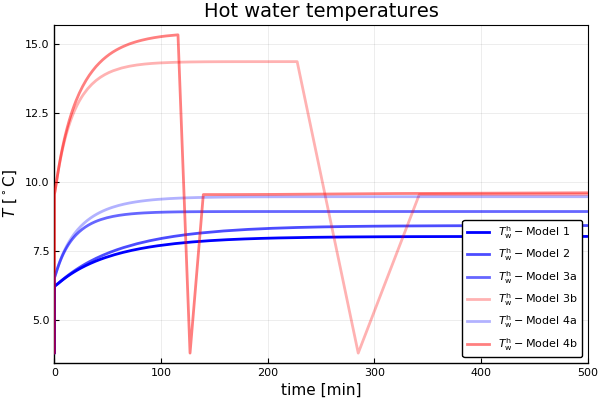

In [19]:
# Compairison of Model 1 and 2

# Metal temperatures
plot(t_model1_DAE/60,Tr_model1_DAE,lc=:darkkhaki ,lw=2,ls=:solid,label=L"$T_\mathrm{r}-\mathrm{Model\ 1}$")
plot!(t_model2_DAE/60,Tr_model2_DAE,lc=:darkkhaki,lw=2,ls=:dash,label=L"$T_\mathrm{r}-\mathrm{Model\ 2}$")
plot!(t_model1_DAE/60,Ts_model1_DAE,lc=:darkgoldenrod,lw=2,ls=:solid,label=L"$T_\mathrm{s}-\mathrm{Model\ 1}$")
plot!(t_model2_DAE/60,Ts_model2_DAE,lc=:darkgoldenrod,lw=2,ls=:dash,label=L"$T_\mathrm{s}-\mathrm{Model\ 2}$")
plot!(t_model1_DAE/60,TFe_model1_DAE,lc=:darkgrey,lw=2,ls=:solid,label=L"$T_\mathrm{Fe}-\mathrm{Model\ 1}$")
plot!(t_model2_DAE/60,TFe_model2_DAE,lc=:darkgrey,lw=2,ls=:dash,label=L"$T_\mathrm{Fe}-\mathrm{Model\ 2}$")
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,500),legend=:bottomright,framestyle=:box);
model1and2metal = plot!(title="Generator metal temperatures\n \$\\mathrm{Model\\ 1}\\ (\\hatc_\\mathrm{p},R)\\ \\mathrm{and}\\ \\mathrm{Model\\ 2}\\ (\\hatc_\\mathrm{p},R(\\mathrm{T}))}\$")
# Air temperatures and water temp
plot(t_model1_DAE/60,Tac_model1_DAE,lc=:red ,lw=2,la=0.3,ls=:solid,label=L"$T_\mathrm{a}^\mathrm{c}-\mathrm{Model\ 1}$")
plot!(t_model2_DAE/60,Tac_model2_DAE,lc=:red,lw=2,la=0.3,ls=:dash,label=L"$T_\mathrm{a}^\mathrm{c}-\mathrm{Model\ 2}$")
plot!(t_model1_DAE/60,Tad_model1_DAE,lc=:red,lw=2,la=0.5,ls=:solid,label=L"$T_\mathrm{a}^\mathrm{\delta}-\mathrm{Model\ 1}$")
plot!(t_model2_DAE/60,Tad_model2_DAE,lc=:red,lw=2,la=0.5,ls=:dash,label=L"$T_\mathrm{a}^\mathrm{\delta}-\mathrm{Model\ 2}$")
plot!(t_model1_DAE/60,Tah_model1_DAE,lc=:red,lw=2,la=1,ls=:solid,label=L"$T_\mathrm{a}^\mathrm{h}-\mathrm{Model\ 1}$")
plot!(t_model2_DAE/60,Tah_model2_DAE,lc=:red,lw=2,la=1,ls=:dash,label=L"$T_\mathrm{a}^\mathrm{h}-\mathrm{Model\ 2}$")
plot!(t_model1_DAE/60,Twh_model1_DAE,lc=:blue,lw=2,la=0.5,ls=:solid,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 1}$")
plot!(t_model2_DAE/60,Twh_model2_DAE,lc=:blue,lw=2,la=0.5,ls=:dash,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 2}$")
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,500),legend=:bottomright,framestyle=:box);
model1and2airwater = plot!(title="Air and water temperatures\n \$\\mathrm{Model\\ 1}\\ (\\hatc_\\mathrm{p},R)\\ \\mathrm{and}\\ \\mathrm{Model\\ 2}\\ (\\hatc_\\mathrm{p},R(\\mathrm{T}))}\$")
# Heat flows
# Air temperatures and water temp
plot(t_model1_DAE/60,Qdr2d_model1_DAE,lc=:red ,lw=2,la=0.5,ls=:solid,label=L"$\dot{Q}_\mathrm{r2\delta}-\mathrm{Model\ 1}$")
plot!(t_model2_DAE/60,Qdr2d_model2_DAE,lc=:red,lw=2,la=0.5,ls=:dot,label=L"$\dot{Q}_\mathrm{r2\delta}-\mathrm{Model\ 2}$")
plot!(t_model1_DAE/60,Qds2Fe_model1_DAE,lc=:red,lw=2,la=1,ls=:solid,label=L"$\dot{Q}_\mathrm{s2Fe}-\mathrm{Model\ 1}$")
plot!(t_model2_DAE/60,Qds2Fe_model2_DAE,lc=:red,lw=2,la=1,ls=:dash,label=L"$\dot{Q}_\mathrm{s2Fe}-\mathrm{Model\ 2}$")
plot!(t_model1_DAE/60,QdFe2a_model1_DAE,lc=:darkgrey,lw=2,la=1,ls=:solid,label=L"$\dot{Q}_\mathrm{Fe2a}-\mathrm{Model\ 1}$")
plot!(t_model2_DAE/60,QdFe2a_model2_DAE,lc=:darkgrey,lw=2,la=1,ls=:dash,label=L"$\dot{Q}_\mathrm{Fe2a}-\mathrm{Model\ 2}$")
#plot!(t_model1_DAE/60,Qdw2a_model1_DAE,lc=:blue,lw=2,la=0.5,ls=:solid,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 1}$")
#plot!(t_model2_DAE/60,Qdw2a_model2_DAE,lc=:blue,lw=2,la=0.5,ls=:dash,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 2}$")
plot!(xlabel="time [min]",ylabel=L"\dot{Q} \mathrm{[kW]}",xlim=(0,500),legend=:bottomright,framestyle=:box);
model1and2heatflows = plot!(title="Heat flows between air and metals\n \$\\mathrm{Model\\ 1}\\ (\\hatc_\\mathrm{p},R)\\ \\mathrm{and}\\ \\mathrm{Model\\ 2}\\ (\\hatc_\\mathrm{p},R(\\mathrm{T}))}\$")

#Compairison of Model 1 and 3a

# Metal temperatures
plot(t_model1_DAE/60,Tr_model1_DAE,lc=:darkkhaki ,lw=2,ls=:solid,label=L"$T_\mathrm{r}-\mathrm{Model\ 1}$")
plot!(t_model3a_DAE/60,Tr_model3a_DAE,lc=:darkkhaki,lw=2,ls=:dash,label=L"$T_\mathrm{r}-\mathrm{Model\ 3a}$")
plot!(t_model1_DAE/60,Ts_model1_DAE,lc=:darkgoldenrod,lw=2,ls=:solid,label=L"$T_\mathrm{s}-\mathrm{Model\ 1}$")
plot!(t_model3a_DAE/60,Ts_model3a_DAE,lc=:darkgoldenrod,lw=2,ls=:dash,label=L"$T_\mathrm{s}-\mathrm{Model\ 3a}$")
plot!(t_model1_DAE/60,TFe_model1_DAE,lc=:darkgrey,lw=2,ls=:solid,label=L"$T_\mathrm{Fe}-\mathrm{Model\ 1}$")
plot!(t_model3a_DAE/60,TFe_model3a_DAE,lc=:darkgrey,lw=2,ls=:dash,label=L"$T_\mathrm{Fe}-\mathrm{Model\ 3a}$")
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,500),legend=:bottomright,framestyle=:box);
model1and3ametal = plot!(title="Generator metal temperatures\n \$\\mathrm{Model\\ 1}\\ (\\hatc_\\mathrm{p},R)\\ \\mathrm{and}\\ \\mathrm{Model\\ 3a}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R)}\$")
# Air temperatures and water temp
plot(t_model1_DAE/60,Tac_model1_DAE,lc=:red ,lw=2,la=0.3,ls=:solid,label=L"$T_\mathrm{a}^\mathrm{c}-\mathrm{Model\ 1}$")
plot!(t_model3a_DAE/60,Tac_model3a_DAE,lc=:red,lw=2,la=0.3,ls=:dash,label=L"$T_\mathrm{a}^\mathrm{c}-\mathrm{Model\ 3a}$")
plot!(t_model1_DAE/60,Tad_model1_DAE,lc=:red,lw=2,la=0.5,ls=:solid,label=L"$T_\mathrm{a}^\mathrm{\delta}-\mathrm{Model\ 1}$")
plot!(t_model3a_DAE/60,Tad_model3a_DAE,lc=:red,lw=2,la=0.5,ls=:dash,label=L"$T_\mathrm{a}^\mathrm{\delta}-\mathrm{Model\ 3a}$")
plot!(t_model1_DAE/60,Tah_model1_DAE,lc=:red,lw=2,la=1,ls=:solid,label=L"$T_\mathrm{a}^\mathrm{h}-\mathrm{Model\ 1}$")
plot!(t_model3a_DAE/60,Tah_model3a_DAE,lc=:red,lw=2,la=1,ls=:dash,label=L"$T_\mathrm{a}^\mathrm{h}-\mathrm{Model\ 3a}$")
plot!(t_model1_DAE/60,Twh_model1_DAE,lc=:blue,lw=2,la=0.5,ls=:solid,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 1}$")
plot!(t_model3a_DAE/60,Twh_model3a_DAE,lc=:blue,lw=2,la=0.5,ls=:dash,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 3a}$")
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,500),legend=:bottomright,framestyle=:box);
model1and3aairwater = plot!(title="Air and water temperatures\n \$\\mathrm{Model\\ 1}\\ (\\hatc_\\mathrm{p},R)\\ \\mathrm{and}\\ \\mathrm{Model\\ 3a}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R)}\$")
# Heat flows
# Air temperatures and water temp
plot(t_model1_DAE/60,Qdr2d_model1_DAE,lc=:red ,lw=2,la=0.5,ls=:solid,label=L"$\dot{Q}_\mathrm{r2\delta}-\mathrm{Model\ 1}$")
plot!(t_model3a_DAE/60,Qdr2d_model3a_DAE,lc=:red,lw=2,la=0.5,ls=:dot,label=L"$\dot{Q}_\mathrm{r2\delta}-\mathrm{Model\ 3a}$")
plot!(t_model1_DAE/60,Qds2Fe_model1_DAE,lc=:red,lw=2,la=1,ls=:solid,label=L"$\dot{Q}_\mathrm{s2Fe}-\mathrm{Model\ 1}$")
plot!(t_model3a_DAE/60,Qds2Fe_model3a_DAE,lc=:red,lw=2,la=1,ls=:dash,label=L"$\dot{Q}_\mathrm{s2Fe}-\mathrm{Model\ 3a}$")
plot!(t_model1_DAE/60,QdFe2a_model1_DAE,lc=:darkgrey,lw=2,la=1,ls=:solid,label=L"$\dot{Q}_\mathrm{Fe2a}-\mathrm{Model\ 1}$")
plot!(t_model3a_DAE/60,QdFe2a_model3a_DAE,lc=:darkgrey,lw=2,la=1,ls=:dash,label=L"$\dot{Q}_\mathrm{Fe2a}-\mathrm{Model\ 3a}$")
#plot!(t_model1_DAE/60,Qdw2a_model1_DAE,lc=:blue,lw=2,la=0.5,ls=:solid,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 1}$")
#plot!(t_model3a_DAE/60,Qdw2a_model3a_DAE,lc=:blue,lw=2,la=0.5,ls=:dash,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 3a}$")
plot!(xlabel="time [min]",ylabel=L"\dot{Q} \mathrm{[kW]}",xlim=(0,500),legend=:bottomright,framestyle=:box);
model1and3aheatflows = plot!(title="Heat flows between air and metals\n \$\\mathrm{Model\\ 1}\\ (\\hatc_\\mathrm{p},R)\\ \\mathrm{and}\\ \\mathrm{Model\\ 3a}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R)}\$")

# Comparison of Model 3a and 3b
# Metal temperatures
plot(t_model3a_DAE/60,Tr_model3a_DAE,lc=:darkkhaki ,lw=2,ls=:solid,label=L"$T_\mathrm{r}-\mathrm{Model\ 3a}$")
plot!(t_model3b_DAE/60,Tr_model3b_DAE,lc=:darkkhaki,lw=2,ls=:dash,label=L"$T_\mathrm{r}-\mathrm{Model\ 3b}$")
plot!(t_model3a_DAE/60,Ts_model3a_DAE,lc=:darkgoldenrod,lw=2,ls=:solid,label=L"$T_\mathrm{s}-\mathrm{Model\ 3a}$")
plot!(t_model3b_DAE/60,Ts_model3b_DAE,lc=:darkgoldenrod,lw=2,ls=:dash,label=L"$T_\mathrm{s}-\mathrm{Model\ 3b}$")
plot!(t_model3a_DAE/60,TFe_model3a_DAE,lc=:darkgrey,lw=2,ls=:solid,label=L"$T_\mathrm{Fe}-\mathrm{Model\ 3a}$")
plot!(t_model3b_DAE/60,TFe_model3b_DAE,lc=:darkgrey,lw=2,ls=:dash,label=L"$T_\mathrm{Fe}-\mathrm{Model\ 3b}$")
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,500),legend=:bottomright,framestyle=:box);
model3aand3bmetal = plot!(title="Generator metal temperatures\n \$\\mathrm{Model\\ 3a}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R)\\ \\mathrm{and}\\ \\mathrm{Model\\ 3b}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R)}\$")
# Air temperatures and water temp
plot(t_model3a_DAE/60,Tac_model3a_DAE,lc=:red ,lw=2,la=0.3,ls=:solid,label=L"$T_\mathrm{a}^\mathrm{c}-\mathrm{Model\ 3a}$")
plot!(t_model3b_DAE/60,Tac_model3b_DAE,lc=:red,lw=2,la=0.3,ls=:dash,label=L"$T_\mathrm{a}^\mathrm{c}-\mathrm{Model\ 3b}$")
plot!(t_model3a_DAE/60,Tad_model3a_DAE,lc=:red,lw=2,la=0.5,ls=:solid,label=L"$T_\mathrm{a}^\mathrm{\delta}-\mathrm{Model\ 3a}$")
plot!(t_model3b_DAE/60,Tad_model3b_DAE,lc=:red,lw=2,la=0.5,ls=:dash,label=L"$T_\mathrm{a}^\mathrm{\delta}-\mathrm{Model\ 3b}$")
plot!(t_model3a_DAE/60,Tah_model3a_DAE,lc=:red,lw=2,la=1,ls=:solid,label=L"$T_\mathrm{a}^\mathrm{h}-\mathrm{Model\ 3a}$")
plot!(t_model3b_DAE/60,Tah_model3b_DAE,lc=:red,lw=2,la=1,ls=:dash,label=L"$T_\mathrm{a}^\mathrm{h}-\mathrm{Model\ 3b}$")
plot!(t_model3a_DAE/60,Twh_model3a_DAE,lc=:blue,lw=2,la=0.5,ls=:solid,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 3a}$")
plot!(t_model3b_DAE/60,Twh_model3b_DAE,lc=:blue,lw=2,la=0.5,ls=:dash,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 3b}$")
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,500),legend=:bottomright,framestyle=:box);
model3aand3bairwater = plot!(title="Air and water temperatures\n \$\\mathrm{Model\\ 3a}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R)\\ \\mathrm{and}\\ \\mathrm{Model\\ 3b}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R)}\$")
# Heat flows
plot(t_model3a_DAE/60,Qdr2d_model3a_DAE,lc=:red ,lw=2,la=0.5,ls=:solid,label=L"$\dot{Q}_\mathrm{r2\delta}-\mathrm{Model\ 3a}$")
plot!(t_model3b_DAE/60,Qdr2d_model3b_DAE,lc=:red,lw=2,la=0.5,ls=:dot,label=L"$\dot{Q}_\mathrm{r2\delta}-\mathrm{Model\ 3b}$")
plot!(t_model3a_DAE/60,Qds2Fe_model3a_DAE,lc=:red,lw=2,la=1,ls=:solid,label=L"$\dot{Q}_\mathrm{s2Fe}-\mathrm{Model\ 3a}$")
plot!(t_model3b_DAE/60,Qds2Fe_model3b_DAE,lc=:red,lw=2,la=1,ls=:dash,label=L"$\dot{Q}_\mathrm{s2Fe}-\mathrm{Model\ 3b}$")
plot!(t_model3a_DAE/60,QdFe2a_model3a_DAE,lc=:darkgrey,lw=2,la=1,ls=:solid,label=L"$\dot{Q}_\mathrm{Fe2a}-\mathrm{Model\ 3a}$")
plot!(t_model3b_DAE/60,QdFe2a_model3b_DAE,lc=:darkgrey,lw=2,la=1,ls=:dash,label=L"$\dot{Q}_\mathrm{Fe2a}-\mathrm{Model\ 3b}$")
#plot!(t_model3a_DAE/60,Qdw2a_model3a_DAE,lc=:blue,lw=2,la=0.5,ls=:solid,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 3a}$")
#plot!(t_model3b_DAE/60,Qdw2a_model3b_DAE,lc=:blue,lw=2,la=0.5,ls=:dash,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 3b}$")
plot!(xlabel="time [min]",ylabel=L"\dot{Q} \mathrm{[kW]}",xlim=(0,500),legend=:bottomright,framestyle=:box);
model3aand3bheatflows = plot!(title="Heat flows between air and metals\n \$\\mathrm{Model\\ 3a}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R)\\ \\mathrm{and}\\ \\mathrm{Model\\ 3b}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R)}\$")

# Comparison model 4a and 4b
# Metal temperatures
plot(t_model4a_DAE/60,Tr_model4a_DAE,lc=:darkkhaki ,lw=2,ls=:solid,label=L"$T_\mathrm{r}-\mathrm{Model\ 4a}$")
plot!(t_model4b_DAE/60,Tr_model4b_DAE,lc=:darkkhaki,lw=2,ls=:dash,label=L"$T_\mathrm{r}-\mathrm{Model\ 4b}$")
plot!(t_model4a_DAE/60,Ts_model4a_DAE,lc=:darkgoldenrod,lw=2,ls=:solid,label=L"$T_\mathrm{s}-\mathrm{Model\ 4a}$")
plot!(t_model4b_DAE/60,Ts_model4b_DAE,lc=:darkgoldenrod,lw=2,ls=:dash,label=L"$T_\mathrm{s}-\mathrm{Model\ 4b}$")
plot!(t_model4a_DAE/60,TFe_model4a_DAE,lc=:darkgrey,lw=2,ls=:solid,label=L"$T_\mathrm{Fe}-\mathrm{Model\ 4a}$")
plot!(t_model4b_DAE/60,TFe_model4b_DAE,lc=:darkgrey,lw=2,ls=:dash,label=L"$T_\mathrm{Fe}-\mathrm{Model\ 4b}$")
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,500),legend=:bottomright,framestyle=:box);
model4aand4bmetal = plot!(title="Generator metal temperatures\n \$\\mathrm{Model\\ 4a}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R)\\ \\mathrm{and}\\ \\mathrm{Model\\ 4b}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R(\\mathrm{T})}\$")
# Air temperatures and water temp
plot(t_model4a_DAE/60,Tac_model4a_DAE,lc=:red ,lw=2,la=0.3,ls=:solid,label=L"$T_\mathrm{a}^\mathrm{c}-\mathrm{Model\ 4a}$")
plot!(t_model4b_DAE/60,Tac_model4b_DAE,lc=:red,lw=2,la=0.3,ls=:dash,label=L"$T_\mathrm{a}^\mathrm{c}-\mathrm{Model\ 4b}$")
plot!(t_model4a_DAE/60,Tad_model4a_DAE,lc=:red,lw=2,la=0.5,ls=:solid,label=L"$T_\mathrm{a}^\mathrm{\delta}-\mathrm{Model\ 4a}$")
plot!(t_model4b_DAE/60,Tad_model4b_DAE,lc=:red,lw=2,la=0.5,ls=:dash,label=L"$T_\mathrm{a}^\mathrm{\delta}-\mathrm{Model\ 4b}$")
plot!(t_model4a_DAE/60,Tah_model4a_DAE,lc=:red,lw=2,la=1,ls=:solid,label=L"$T_\mathrm{a}^\mathrm{h}-\mathrm{Model\ 4a}$")
plot!(t_model4b_DAE/60,Tah_model4b_DAE,lc=:red,lw=2,la=1,ls=:dash,label=L"$T_\mathrm{a}^\mathrm{h}-\mathrm{Model\ 4b}$")
plot!(t_model4a_DAE/60,Twh_model4a_DAE,lc=:blue,lw=2,la=0.5,ls=:solid,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 4a}$")
plot!(t_model4b_DAE/60,Twh_model4b_DAE,lc=:blue,lw=2,la=0.5,ls=:dash,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 4b}$")
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,500),legend=:bottomright,framestyle=:box);
model4aand4bairwater = plot!(title="Air and water temperatures\n \$\\mathrm{Model\\ 4a}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R)\\ \\mathrm{and}\\ \\mathrm{Model\\ 4b}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R(\\mathrm{T})}\$")
# Heat flows
plot(t_model4a_DAE/60,Qdr2d_model4a_DAE,lc=:red ,lw=2,la=0.5,ls=:solid,label=L"$\dot{Q}_\mathrm{r2\delta}-\mathrm{Model\ 4a}$")
plot!(t_model4b_DAE/60,Qdr2d_model4b_DAE,lc=:red,lw=2,la=0.5,ls=:dot,label=L"$\dot{Q}_\mathrm{r2\delta}-\mathrm{Model\ 4b}$")
plot!(t_model4a_DAE/60,Qds2Fe_model4a_DAE,lc=:red,lw=2,la=1,ls=:solid,label=L"$\dot{Q}_\mathrm{s2Fe}-\mathrm{Model\ 4a}$")
plot!(t_model4b_DAE/60,Qds2Fe_model4b_DAE,lc=:red,lw=2,la=1,ls=:dash,label=L"$\dot{Q}_\mathrm{s2Fe}-\mathrm{Model\ 4b}$")
plot!(t_model4a_DAE/60,QdFe2a_model4a_DAE,lc=:darkgrey,lw=2,la=1,ls=:solid,label=L"$\dot{Q}_\mathrm{Fe2a}-\mathrm{Model\ 4a}$")
plot!(t_model4b_DAE/60,QdFe2a_model4b_DAE,lc=:darkgrey,lw=2,la=1,ls=:dash,label=L"$\dot{Q}_\mathrm{Fe2a}-\mathrm{Model\ 4b}$")
#plot!(t_model4a_DAE/60,Qdw2a_model4a_DAE,lc=:blue,lw=2,la=0.5,ls=:solid,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 4a}$")
#plot!(t_model4b_DAE/60,Qdw2a_model4b_DAE,lc=:blue,lw=2,la=0.5,ls=:dash,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 4b}$")
plot!(xlabel="time [min]",ylabel=L"\dot{Q} \mathrm{[kW]}",xlim=(0,500),legend=:bottomright,framestyle=:box);
model4aand4bheatflows = plot!(title="Heat flows between air and metals\n \$\\mathrm{Model\\ 4a}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R)\\ \\mathrm{and}\\ \\mathrm{Model\\ 4b}\\ (\\hatc_\\mathrm{p}(\\mathrm{T}),R(\\mathrm{T})}\$")



# Comparision of heat flow from water to air for all models
plot(t_model1_DAE/60,Qdw2a_model1_DAE,lc=:blue,lw=2,la=0.4,ls=:solid,label=L"$\dot{Q}_\mathrm{w2a}-\mathrm{Model\ 1}$")
plot!(t_model2_DAE/60,Qdw2a_model2_DAE,lc=:blue,lw=2,la=0.6,ls=:solid,label=L"$\dot{Q}_\mathrm{w2a}-\mathrm{Model\ 2}$")
plot!(t_model3a_DAE/60,Qdw2a_model3a_DAE,lc=:blue,lw=2,la=0.8,ls=:solid,label=L"$\dot{Q}_\mathrm{w2a}-\mathrm{Model\ 3a}$")
plot!(t_model4a_DAE/60,Qdw2a_model4a_DAE,lc=:blue,lw=2,la=1,ls=:solid,label=L"$\dot{Q}_\mathrm{w2a}-\mathrm{Model\ 4a}$")
plot!(xlabel="time [min]",ylabel=L"\dot{Q} \mathrm{[kW]}",xlim=(0,500),legend=:bottomright,framestyle=:box)
model123a4aheatflows = plot!(title="Heat flows from water to air")

# Comparison of hot water temperature for all models
plot(t_model1_DAE/60,Twh_model1_DAE,lc=:blue,lw=2,la=1,ls=:solid,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 1}$")
plot!(t_model2_DAE/60,Twh_model2_DAE,lc=:blue,lw=2,la=0.7,ls=:solid,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 2}$")
plot!(t_model3a_DAE/60,Twh_model3a_DAE,lc=:blue,lw=2,la=0.6,ls=:solid,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 3a}$")
plot!(t_model3b_DAE/60,Twh_model3b_DAE,lc=:red,lw=2,la=0.3,ls=:solid,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 3b}$")
plot!(t_model4a_DAE/60,Twh_model4a_DAE,lc=:blue,lw=2,la=0.3,ls=:solid,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 4a}$")
plot!(t_model4b_DAE/60,Twh_model4b_DAE,lc=:red,lw=2,la=0.5,ls=:solid,label=L"$T_\mathrm{w}^\mathrm{h}-\mathrm{Model\ 4b}$")
plot!(xlabel="time [min]",ylabel=L"$T$ [${}^\circ$C]",xlim=(0,500),legend=:bottomright,framestyle=:box);
model123a4ahotwater = plot!(title="Hot water temperatures")


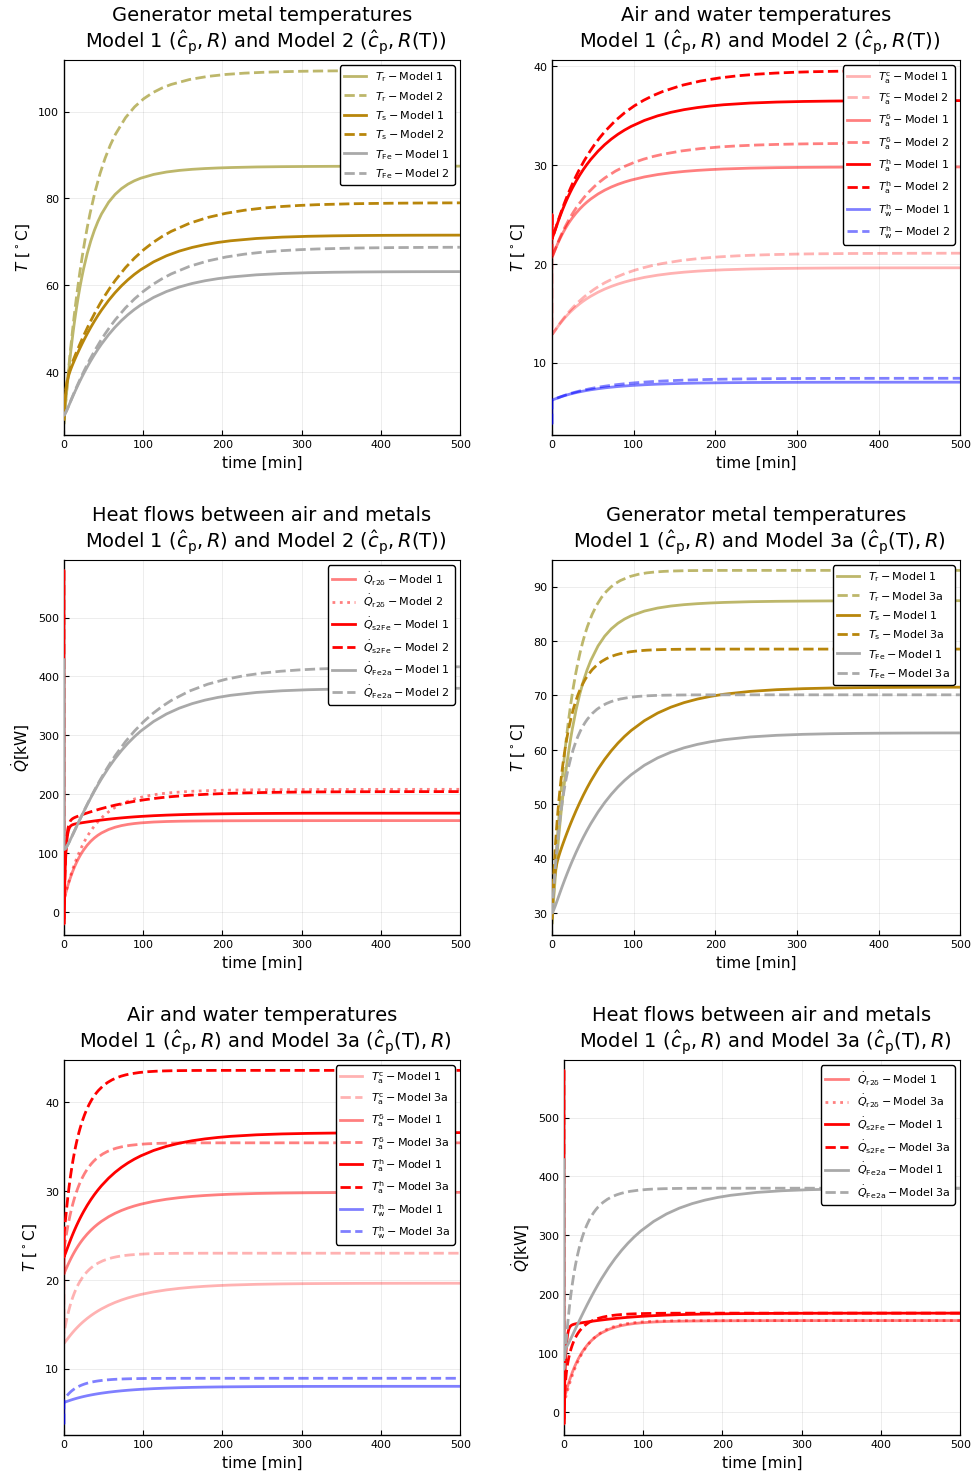

In [311]:
figpath = "C:/Users/pande/Desktop/Desktop/Thesis/ThesisLyx/figures/chapter4/";
using Plots.PlotMeasures
using Plots
pyplot();
measured_data=plot(model1and2metal,model1and2airwater,model1and2heatflows,model1and3ametal,
model1and3aairwater,model1and3aheatflows,
        layout=grid(3,2),size = (1000, 1500),framestyle = :box,
        bottom_margin=10mm,right_margin=10mm,legend=:topright)
figfile="modelcomparisonwithnomialinputs1and2.svg"
savefig(figpath*figfile)

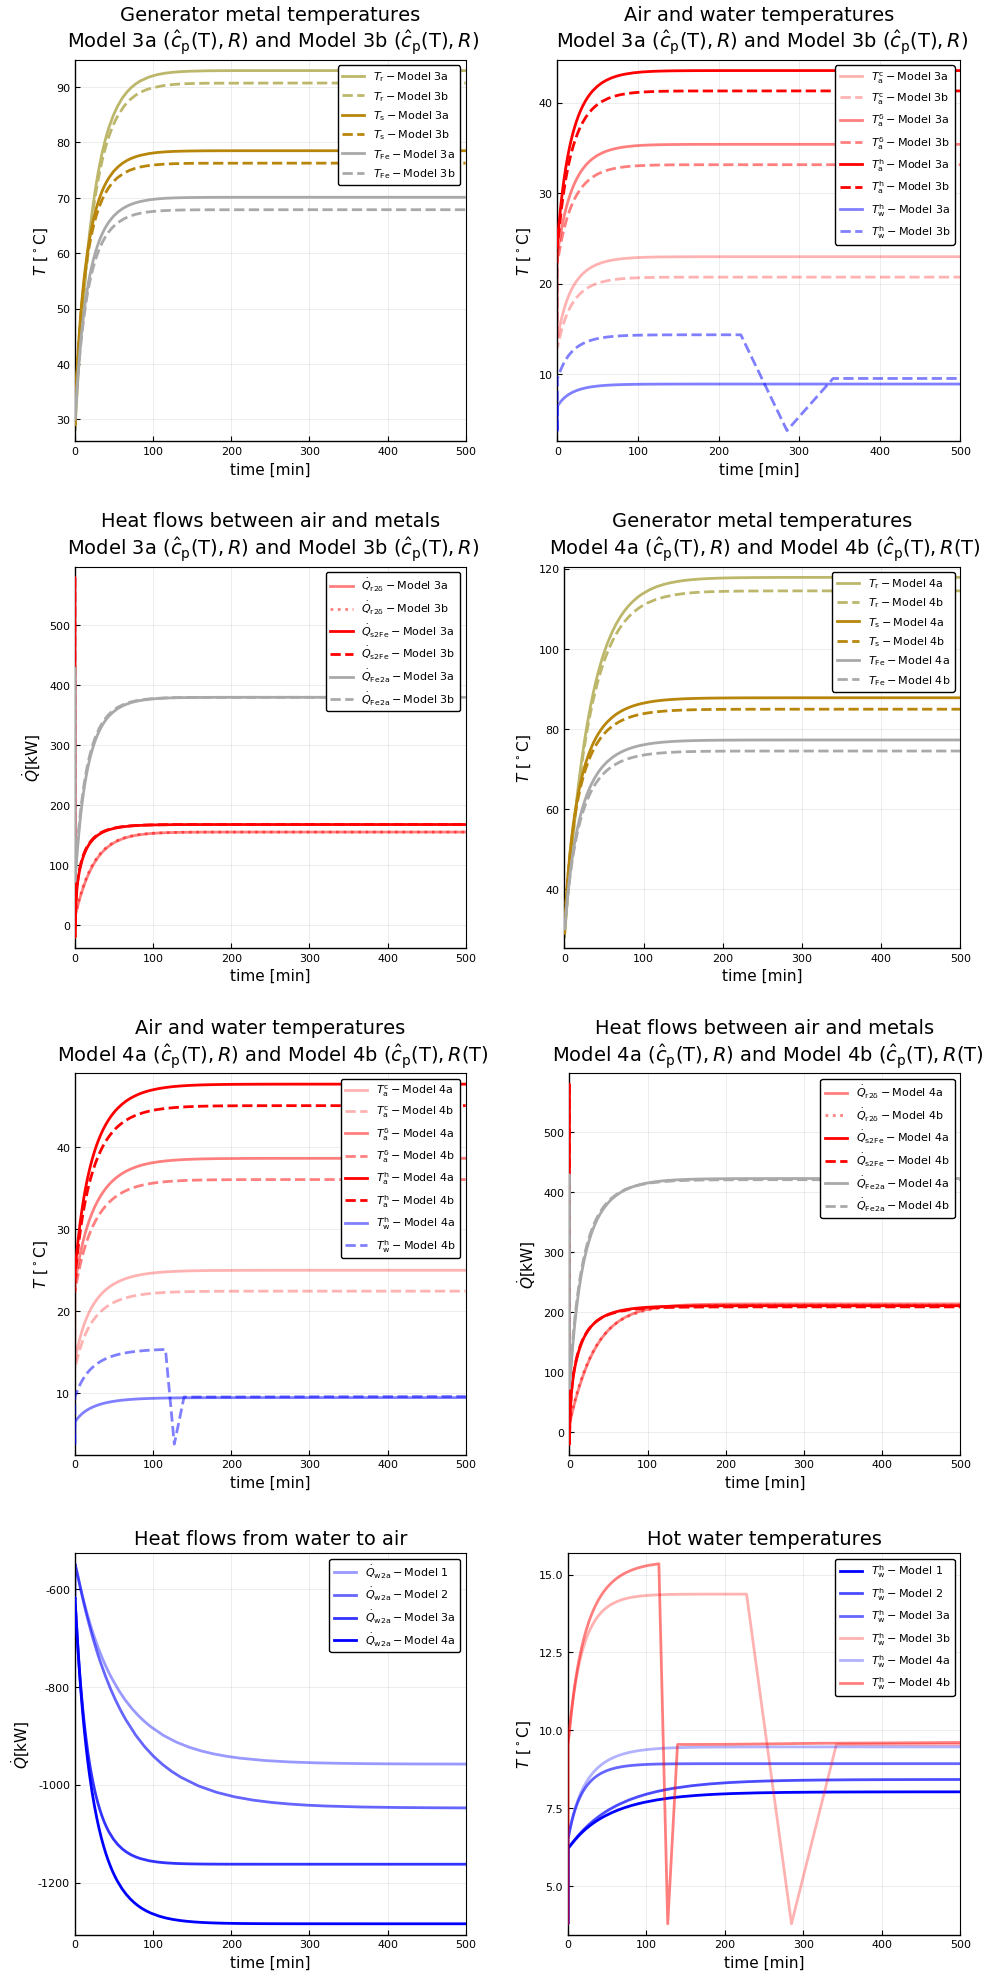

In [20]:
measured_data=plot(model3aand3bmetal,model3aand3bairwater,
model3aand3bheatflows,model4aand4bmetal,model4aand4bairwater,
model4aand4bheatflows,model123a4aheatflows,model123a4ahotwater,
        layout=grid(4,2),size = (1000, 2000),framestyle = :box,
        bottom_margin=10mm,right_margin=10mm,legend=:topright)
figfile="modelcomparisonwithnomialinputs3a3b4a4bandall.svg"
savefig(figpath*figfile)

In [326]:
Tah_model1_DAE

67-element Array{Float64,1}:
 25.0              
 22.554863021128284
 22.555038684520742
 22.555390171592677
 22.55609378547259 
 22.557503560923852
 22.56033321326121 
 22.56603221991976 
 22.571770235533307
 22.57754657763746 
 22.589187135380858
 22.600963113585607
 22.6128798522794  
  ⋮                
 35.83679244658344 
 35.99872926409259 
 36.123666491645814
 36.294082595721314
 36.394863655287836
 36.4547674987476  
 36.491042964749134
 36.513172005970866
 36.526395712608206
 36.534158244135625
 36.53883781673663 
 36.541620805910654

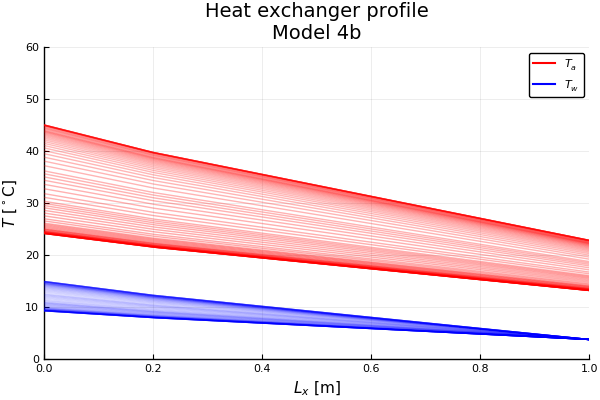

In [332]:
# Plotting Model 1,2,3,4 heat exchanger profile counter current

# Model 1
Tah = zeros(67)
Tah = Tah_model1_DAE
#Tah[1]=Tah_model1_DAE[1]
#for i=2:length(Tah)
    #Tah[i]=Tah_model1_DAE[10*(i-1)]
#end

ploting=plot(1,1,lc=:red,la=1,lw=1.5,label=L"$T_a^\mathrm{}$")
plot!(1,1,lc=:blue,la=1,lw=1.5,label=L"$T_w^\mathrm{}$")

# For gradient of temperatures
hot_color = range(0.4,length=length(Tah),stop=0.2)
cold_color = range(0.2,length=length(Tah),stop=0.1)
color_index = 1
for (index, Tah_value) in enumerate(Tah)
    Up,mda,mdw,aa,ba,aw,bw,chpa,chpw=44.4,49.2,53.9,3.42,1.21e-04,3.86,4.01e-04,1.15,4.2
    p=[Up,mda,mdw,aa,ba,aw,bw,chpa,chpw]
    #length span of heat exchanger
    xspan=(0.0,1.)
    function heatExchanger!(dT,T,p,time)
        #Note that heatexchanger model of bernt lie and that of
        #project description x-direction is opposite so we neglect - sign in the formula here
        #T[1]=Ta
        #T[2]=Tw
        dT[1]=Up/(chpa*mda)*(T[2]-T[1])
        dT[2]=Up/(chpw*mdw)*(T[2]-T[1])
        #dT[3]=p[1]*(T[2]-T[1])
    end

    ##initialGuess=[Tah,Twh]
    initialGuess=[42.27,3.8]
    function bc!(residual,T,p,time)
        residual[1]=T[1][1]-Tah_value#Tah
        residual[2]=T[end][2]-3.8#Twc
    end

    bvp=BVProblem(heatExchanger!,bc!,initialGuess,xspan,p)
    sol=solve(bvp, Shooting(Vern7()))
    plot!(sol.t,[sol.u[i][1] for i in 1:length(sol.t)],la=hot_color[index],lc=:red,lw=1,label="" )#smooth=false
    ploting=plot!(sol.t,[sol.u[i][2] for i in 1:length(sol.t)],la=cold_color[index],lc=:blue,lw=1, label="", reuse=false)
end
plot!(ylabel=L"$T$ [${}^\circ$C]",xlabel=L"L_x\ \mathrm{[m]}" );
plot!(title="Heat exchanger profile\nModel 1",legend=:topright)
model1_HEProfile=plot!(xlim=(0,1),ylim=(0,60),reuse=false)

# Model 2
Tah = zeros(67)
Tah = Tah_model2_DAE

ploting=plot(1,1,lc=:red,la=1,lw=1.5,label=L"$T_a^\mathrm{}$")
plot!(1,1,lc=:blue,la=1,lw=1.5,label=L"$T_w^\mathrm{}$")
# For gradient of temperatures
hot_color = range(0.4,length=length(Tah),stop=0.2)
cold_color = range(0.2,length=length(Tah),stop=0.1)
for (index, Tah_value) in enumerate(Tah)
    Up,mda,mdw,aa,ba,aw,bw,chpa,chpw=44.4,49.2,53.9,3.42,1.21e-04,3.86,4.01e-04,1.15,4.2
    p=[Up,mda,mdw,aa,ba,aw,bw,chpa,chpw]
    #length span of heat exchanger
    xspan=(0.0,1.)
    function heatExchanger!(dT,T,p,time)
        #T[1]=Ta
        #T[2]=Tw
        dT[1]=Up/(chpa*mda)*(T[2]-T[1])
        dT[2]=Up/(chpw*mdw)*(T[2]-T[1])
    end
    ##initialGuess=[Tah,Twh]
    initialGuess=[42.27,3.8]
    function bc!(residual,T,p,time)
        residual[1]=T[1][1]-Tah_value#Tah
        residual[2]=T[end][2]-3.8#Twc
    end
    bvp=BVProblem(heatExchanger!,bc!,initialGuess,xspan,p)
    sol=solve(bvp, Shooting(Vern7()))
    plot!(sol.t,[sol.u[i][1] for i in 1:length(sol.t)],la=hot_color[index],lc=:red,lw=1,label="" )#smooth=false
    ploting=plot!(sol.t,[sol.u[i][2] for i in 1:length(sol.t)],la=cold_color[index],lc=:blue,lw=1, label="", reuse=false)
end
plot!(ylabel=L"$T$ [${}^\circ$C]",xlabel=L"L_x\ \mathrm{[m]}" );
plot!(title="Heat exchanger profile\nModel 2",legend=:topright)
model2_HEProfile=plot!(xlim=(0,1),ylim=(0,60),reuse=false)

# Model 3a
# Model 2
Tah = zeros(67)
Tah = Tah_model3a_DAE

ploting=plot(1,1,lc=:red,la=1,lw=1.5,label=L"$T_a^\mathrm{}$")
plot!(1,1,lc=:blue,la=1,lw=1.5,label=L"$T_w^\mathrm{}$")
# For gradient of temperatures
hot_color = range(0.4,length=length(Tah),stop=0.2)
cold_color = range(0.2,length=length(Tah),stop=0.1)
for (index, Tah_value) in enumerate(Tah)
    Up,mda,mdw,aa,ba,aw,bw,chpa,chpw=44.4,49.2,53.9,3.42,1.21e-04,3.86,4.01e-04,1.15,4.2
    p=[Up,mda,mdw,aa,ba,aw,bw,chpa,chpw]
    #length span of heat exchanger
    xspan=(0.0,1.)
    function heatExchanger!(dT,T,p,time)
        #T[1]=Ta
        #T[2]=Tw
        dT[1]=Up/(chpa*mda)*(T[2]-T[1])
        dT[2]=Up/(chpw*mdw)*(T[2]-T[1])
    end
    ##initialGuess=[Tah,Twh]
    initialGuess=[42.27,3.8]
    function bc!(residual,T,p,time)
        residual[1]=T[1][1]-Tah_value#Tah
        residual[2]=T[end][2]-3.8#Twc
    end
    bvp=BVProblem(heatExchanger!,bc!,initialGuess,xspan,p)
    sol=solve(bvp, Shooting(Vern7()))
    plot!(sol.t,[sol.u[i][1] for i in 1:length(sol.t)],la=hot_color[index],lc=:red,lw=1,label="" )#smooth=false
    ploting=plot!(sol.t,[sol.u[i][2] for i in 1:length(sol.t)],la=cold_color[index],lc=:blue,lw=1, label="", reuse=false)
end
plot!(ylabel=L"$T$ [${}^\circ$C]",xlabel=L"L_x\ \mathrm{[m]}" );
plot!(title="Heat exchanger profile\nModel 3a",legend=:topright)
model3a_HEProfile=plot!(xlim=(0,1),ylim=(0,60),reuse=false)



# Model 3b
Tah = zeros(67)
Tah = Tah_model3b_DAE

ploting=plot(1,1,lc=:red,la=1,lw=1.5,label=L"$T_a^\mathrm{}$")
plot!(1,1,lc=:blue,la=1,lw=1.5,label=L"$T_w^\mathrm{}$")
# For gradient of temperatures
hot_color = range(0.4,length=length(Tah),stop=0.2)
cold_color = range(0.2,length=length(Tah),stop=0.1)
for (index, Tah_value) in enumerate(Tah)
    Up,mda,mdw,aa,ba,aw,bw,chpa,chpw,R,Ma,Mw=44.4,49.2,53.9,3.42,1.21e-04,3.86,4.01e-04,1.15,4.2,8.314,28.97,18.01
    p=[Up,mda,mdw,aa,ba,aw,bw,chpa,chpw,R,Ma,Mw]
    #length span of heat exchanger
    xspan=(0.0,1.)
    function heatExchanger!(dT,T,p,time)
        #T[1]=Ta
        #T[2]=Tw
        dT[1]=Up/((R/Ma*(aa+ba*T[1])*mda))*(T[2]-T[1])#R/Ma*(aa+ba*T[1])
        dT[2]=Up/((R/Mw*(aw+bw*T[2])*mdw))*(T[2]-T[1])#R/Mw*(aw+bw*T[2]
    end
    ##initialGuess=[Tah,Twh]
    initialGuess=[42.27,3.8]
    function bc!(residual,T,p,time)
        residual[1]=T[1][1]-Tah_value#Tah
        residual[2]=T[end][2]-3.8#Twc
    end
    bvp=BVProblem(heatExchanger!,bc!,initialGuess,xspan,p)
    sol=solve(bvp, Shooting(Vern7()))
    plot!(sol.t,[sol.u[i][1] for i in 1:length(sol.t)],la=hot_color[index],lc=:red,lw=1,label="" )#smooth=false
    ploting=plot!(sol.t,[sol.u[i][2] for i in 1:length(sol.t)],la=cold_color[index],lc=:blue,lw=1, label="", reuse=false)
end
plot!(ylabel=L"$T$ [${}^\circ$C]",xlabel=L"L_x\ \mathrm{[m]}" );
plot!(title="Heat exchanger profile\nModel 3b",legend=:topright)
model3b_HEProfile=plot!(xlim=(0,1),ylim=(0,60),reuse=false)

# Model 4a
# Model 2
Tah = zeros(67)
Tah = Tah_model4a_DAE

ploting=plot(1,1,lc=:red,la=1,lw=1.5,label=L"$T_a^\mathrm{}$")
plot!(1,1,lc=:blue,la=1,lw=1.5,label=L"$T_w^\mathrm{}$")
# For gradient of temperatures
hot_color = range(0.4,length=length(Tah),stop=0.2)
cold_color = range(0.2,length=length(Tah),stop=0.1)
for (index, Tah_value) in enumerate(Tah)
    Up,mda,mdw,aa,ba,aw,bw,chpa,chpw=44.4,49.2,53.9,3.42,1.21e-04,3.86,4.01e-04,1.15,4.2
    p=[Up,mda,mdw,aa,ba,aw,bw,chpa,chpw]
    #length span of heat exchanger
    xspan=(0.0,1.)
    function heatExchanger!(dT,T,p,time)
        #T[1]=Ta
        #T[2]=Tw
        dT[1]=Up/(chpa*mda)*(T[2]-T[1])
        dT[2]=Up/(chpw*mdw)*(T[2]-T[1])
    end
    ##initialGuess=[Tah,Twh]
    initialGuess=[42.27,3.8]
    function bc!(residual,T,p,time)
        residual[1]=T[1][1]-Tah_value#Tah
        residual[2]=T[end][2]-3.8#Twc
    end
    bvp=BVProblem(heatExchanger!,bc!,initialGuess,xspan,p)
    sol=solve(bvp, Shooting(Vern7()))
    plot!(sol.t,[sol.u[i][1] for i in 1:length(sol.t)],la=hot_color[index],lc=:red,lw=1,label="" )#smooth=false
    ploting=plot!(sol.t,[sol.u[i][2] for i in 1:length(sol.t)],la=cold_color[index],lc=:blue,lw=1, label="", reuse=false)
end
plot!(ylabel=L"$T$ [${}^\circ$C]",xlabel=L"L_x\ \mathrm{[m]}" );
plot!(title="Heat exchanger profile\nModel 4a",legend=:topright)
model4a_HEProfile=plot!(xlim=(0,1),ylim=(0,60),reuse=false)



# Model 4b
Tah = zeros(67)
Tah = Tah_model4b_DAE

ploting=plot(1,1,lc=:red,la=1,lw=1.5,label=L"$T_a^\mathrm{}$")
plot!(1,1,lc=:blue,la=1,lw=1.5,label=L"$T_w^\mathrm{}$")
# For gradient of temperatures
hot_color = range(0.4,length=length(Tah),stop=0.2)
cold_color = range(0.2,length=length(Tah),stop=0.1)
for (index, Tah_value) in enumerate(Tah)
    Up,mda,mdw,aa,ba,aw,bw,chpa,chpw,R,Ma,Mw=44.4,49.2,53.9,3.42,1.21e-04,3.86,4.01e-04,1.15,4.2,8.314,28.97,18.01
    p=[Up,mda,mdw,aa,ba,aw,bw,chpa,chpw,R,Ma,Mw]
    #length span of heat exchanger
    xspan=(0.0,1.)
    function heatExchanger!(dT,T,p,time)
        #T[1]=Ta
        #T[2]=Tw
        dT[1]=Up/((R/Ma*(aa+ba*T[1])*mda))*(T[2]-T[1])#R/Ma*(aa+ba*T[1])
        dT[2]=Up/((R/Mw*(aw+bw*T[2])*mdw))*(T[2]-T[1])#R/Mw*(aw+bw*T[2]
    end
    ##initialGuess=[Tah,Twh]
    initialGuess=[42.27,3.8]
    function bc!(residual,T,p,time)
        residual[1]=T[1][1]-Tah_value#Tah
        residual[2]=T[end][2]-3.8#Twc
    end
    bvp=BVProblem(heatExchanger!,bc!,initialGuess,xspan,p)
    sol=solve(bvp, Shooting(Vern7()))
    plot!(sol.t,[sol.u[i][1] for i in 1:length(sol.t)],la=hot_color[index],lc=:red,lw=1,label="" )#smooth=false
    ploting=plot!(sol.t,[sol.u[i][2] for i in 1:length(sol.t)],la=cold_color[index],lc=:blue,lw=1, label="", reuse=false)
end
plot!(ylabel=L"$T$ [${}^\circ$C]",xlabel=L"L_x\ \mathrm{[m]}" );
plot!(title="Heat exchanger profile\nModel 4b",legend=:topright)
model4b_HEProfile=plot!(xlim=(0,1),ylim=(0,60),reuse=false)


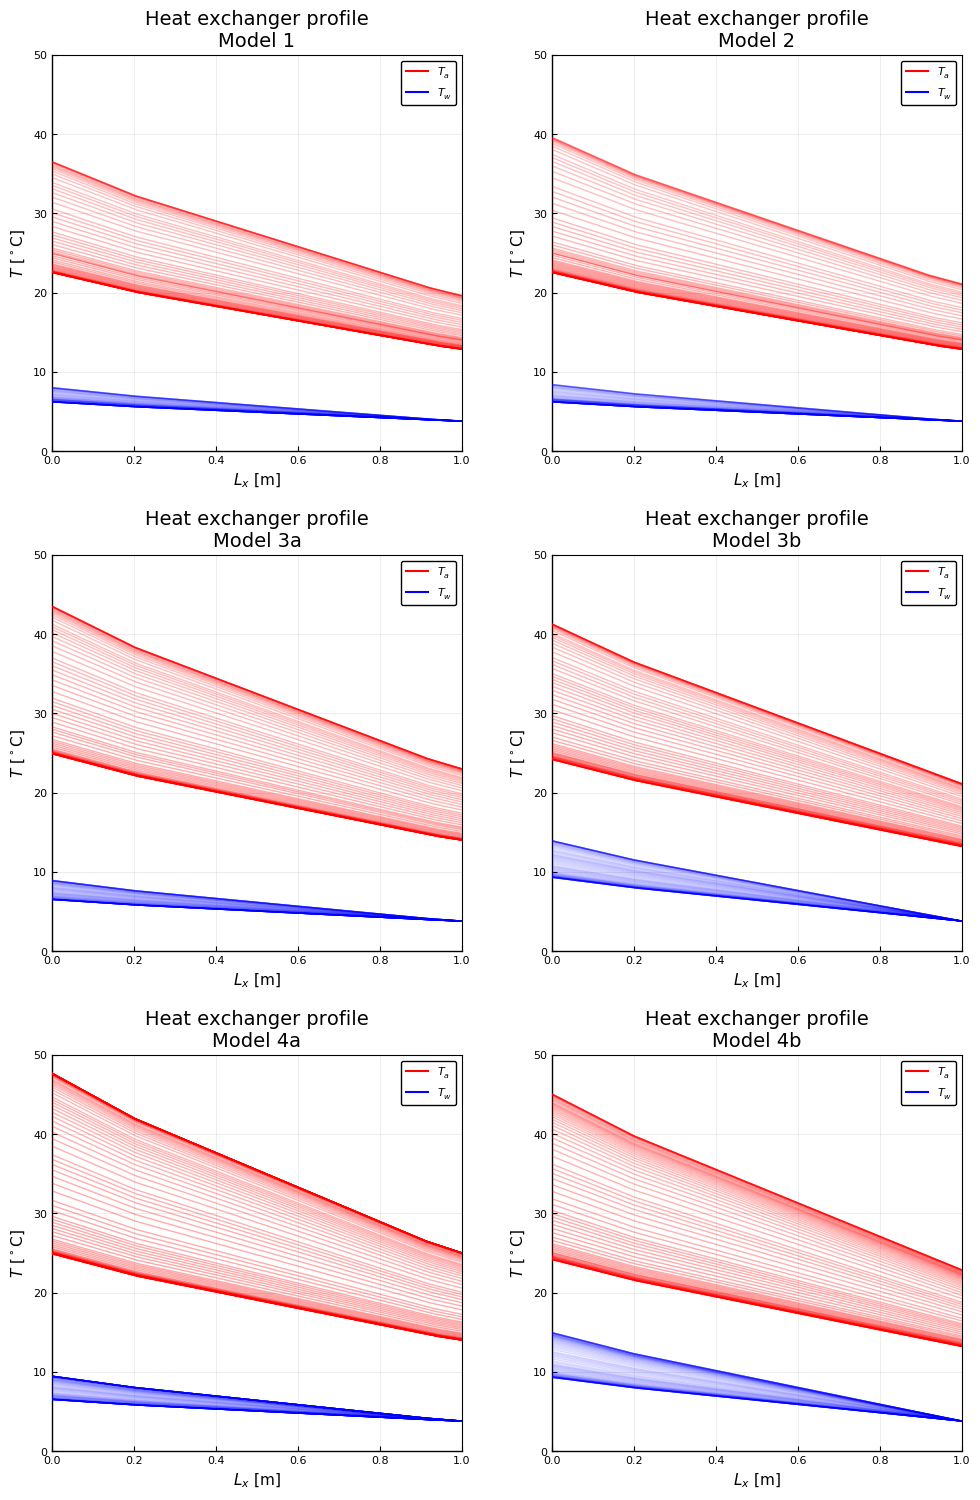

In [335]:
plot(model1_HEProfile,model2_HEProfile,model3a_HEProfile,
    model3b_HEProfile,model4a_HEProfile,model4b_HEProfile,
    layout=grid(3,2),size = (1000,1500),framestyle = :box, bottom_margin=5mm,right_margin=10mm,ylim=(0,50))
figfile="model1234_HEprofile_comparision_plot.svg"
savefig(figpath*figfile)

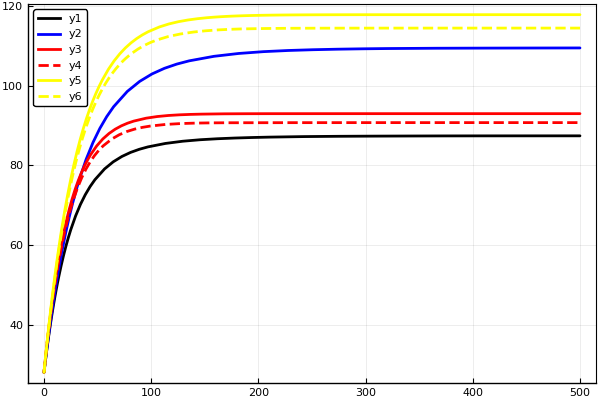

In [23]:

pyplot();
plot(t_model1_DAE/60,Tr_model1_DAE,lw=2,lc=:black,framestyle=:box,ls=:solid)
plot!(t_model2_DAE/60,Tr_model2_DAE,lw=2,lc=:blue,ls=:solid)
plot!(t_model3a_DAE/60,Tr_model3a_DAE,lw=2,lc=:red,ls=:solid)
plot!(t_model3b_DAE/60,Tr_model3b_DAE,lw=2,lc=:red,ls=:dash)
plot!(t_model4a_DAE/60,Tr_model4a_DAE,lw=2,lc=:yellow,ls=:solid)
plot!(t_model4b_DAE/60,Tr_model4b_DAE,lw=2,lc=:yellow,ls=:dash)

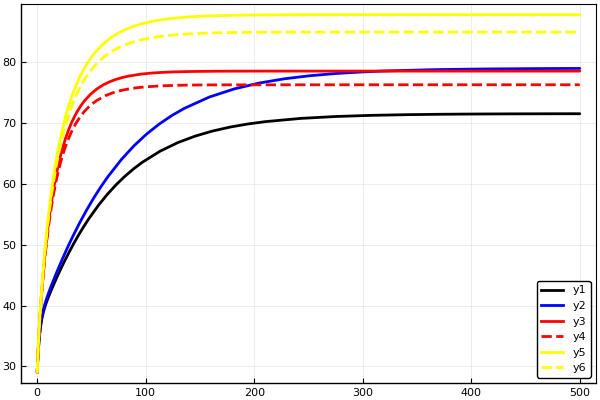

In [24]:

pyplot();
plot(t_model1_DAE/60,Ts_model1_DAE,lw=2,lc=:black,framestyle=:box,ls=:solid)
plot!(t_model2_DAE/60,Ts_model2_DAE,lw=2,lc=:blue,ls=:solid)
plot!(t_model3a_DAE/60,Ts_model3a_DAE,lw=2,lc=:red,ls=:solid)
plot!(t_model3b_DAE/60,Ts_model3b_DAE,lw=2,lc=:red,ls=:dash)
plot!(t_model4a_DAE/60,Ts_model4a_DAE,lw=2,lc=:yellow,ls=:solid)
plot!(t_model4b_DAE/60,Ts_model4b_DAE,lw=2,lc=:yellow,ls=:dash)

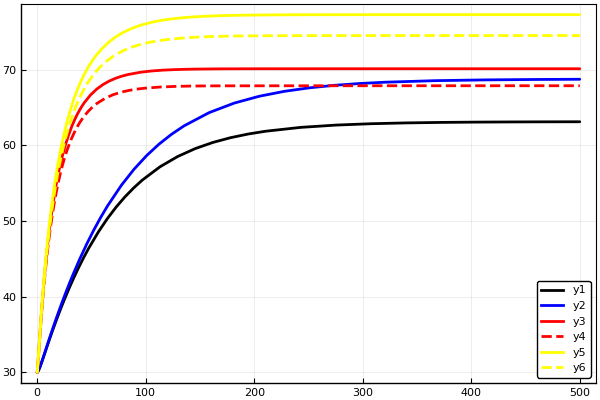

In [25]:

pyplot();
plot(t_model1_DAE/60,TFe_model1_DAE,lw=2,lc=:black,framestyle=:box,ls=:solid)
plot!(t_model2_DAE/60,TFe_model2_DAE,lw=2,lc=:blue,ls=:solid)
plot!(t_model3a_DAE/60,TFe_model3a_DAE,lw=2,lc=:red,ls=:solid)
plot!(t_model3b_DAE/60,TFe_model3b_DAE,lw=2,lc=:red,ls=:dash)
plot!(t_model4a_DAE/60,TFe_model4a_DAE,lw=2,lc=:yellow,ls=:solid)
plot!(t_model4b_DAE/60,TFe_model4b_DAE,lw=2,lc=:yellow,ls=:dash)